# NationStates Data Analysis - SQL

### Now with SQL!

### I would like to also emphasise that a lot of helps has been obtained from various people in NS, on top of Stackoverflow, as well as ChatGPT for some code conversions.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import pymysql
import numpy as np
import pandas as pd
import time
import scipy
import random
import operator
import os
import string
import datetime
import statistics

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter, ScalarFormatter, MultipleLocator, LogLocator, LogFormatterSciNotation
from matplotlib.ticker import AutoLocator, AutoMinorLocator
from matplotlib.ticker import Locator
from matplotlib.pyplot import figure

from matplotlib.colors import LogNorm
import matplotlib.colors as colors

import matplotlib.cbook as cbook
import matplotlib.font_manager as font_manager

import math

from scipy.stats import gaussian_kde

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from numpy import loadtxt

In [4]:
# Global parameters. Mainly for the graphs. May need to run it twice.

plt.rcParams['font.family'] = 'Iosevka'
plt.rcParams.update({'font.size': 20})

pd.set_option("display.max_columns", 400)
pd.set_option("display.max_rows", 20)
pd.set_option('display.min_rows', 20)
pd.set_option('display.expand_frame_repr', True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.display import display, HTML
display(HTML("<style>.jp-Cell { margin-left: -15% !important; margin-right: -15% !important; }</style>"))

In [5]:
# Additional Functions that are required for later.

# Credit: ImportanceOfBeingErnest, https://stackoverflow.com/questions/43324152/python-matplotlib-colorbar-scientific-notation-base
class OOMFormatter(ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

# --------------------------------------------------------------------------
# Credit: unutbu, https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# --------------------------------------------------------------------------
# Credit: David Zwicker and Matt Pitkin, https://stackoverflow.com/questions/20470892/how-to-place-minor-ticks-on-symlog-scale
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))
        
# Symmetrical Log conversion OF THE DATA (not axis), without using Symlog. Credit: ChatGPT.
def symmetrical_log(numbers):
    result = []
    for num in numbers:
        if num > 0:
            result.append(math.log10(num))
        elif num < 0:
            result.append(-math.log10(-num))
        else:
            result.append(0)  # Handle the case when num is 0
    return result

In [6]:
# Connect to Database. Keep the connection open at this point.

db_name = "ns_stats"
db_host = "localhost"
db_username = "root"
db_password = "root"

conn = pymysql.connect(host = db_host,
                       port = int(3306),
                       user = "root",
                       password = db_password,
                       db = db_name)

# Will need this to indicate what dataset is used in graph. Used to be from a .txt file itself, but now using SQL, so...
file_name = "All Nations - 2024-02-28 111820"

In [7]:
# Individual nations analysis. Make a smaller table with proper headers.

# Make data. Choose the stats you want here. Some are capitalised, some are all small letters. Look up the table above and scroll to find the header.
x = "defense forces"
y = "ideological radicality"
z = "population"

xrank = x + " rank"
yrank = y + " rank"
zrank = z + " rank"

XLin = string.capwords(x) + " (X, Linear)"
YLin = string.capwords(y) + " (Y, Linear)"
ZLin = string.capwords(z) + " (Z, Linear)"

XLog = string.capwords(x) + " (X, Log)"
YLog = string.capwords(y) + " (Y, Log)"
ZLog = string.capwords(z) + " (Z, Log)"

# X, Y, Z.
df1 = pd.read_sql_query("""
select
d.`Nation Name` AS `Short Name of the Nation (no pretitle)`,
d.`Region Name`,
d.`population` AS `Population of Nation`,
d.`Number of Issues Answered`,
d.`%s` AS `%s (x)`,
d.`%s` AS `%s (y)`,
d.`%s` AS `%s (z)`
FROM ns_stats.`all nations - 2024-02-28 111820` d
;""" % (x, x, y, y, z, z), conn) 

# ------------------ Sort and filter / cut off

# Random sorting is useful if you don't want to include in biases from "First in, last out."
df1 = df1.reindex(np.random.permutation(df1.index))

# Otherwise, you can use this to sort ascending/descending for a particular column. Defaults to the rightmost column [-1].
# df1.sort_values(by = df1.columns[-1], inplace = True, ascending = True)

# ------------------ Filtering. Add more if needed.
# df1 = df1[(df1["Economic Freedom"] == 0)]

# ----------

# Singling out a list of names. This feature is only for the first graph, not for colormaps.
df2 = df1[(df1["Short Name of the Nation (no pretitle)"] == "valentine_z")]

# ----------

# df1 = df1[(df1["Number of Issues Answered"] >= 10)]

df1 = df1.reset_index(drop=True)
df1.index = df1.index + 1

X = df1[x + " (x)"]
Y = df1[y + " (y)"]
Z = df1[z + " (z)"]
# Y_idx = df1[y_idx]

pd.concat([df1.head(10), df1.tail(10)]).style.format({        # Show Top and Bottom.
# df1.iloc[20:60].style.format({                                  # Show Middle.
    df1.columns[2] : '{:,.0f}', 
    df1.columns[3] : '{:,.0f}', 
    df1.columns[4] : '{:,.0f}', 
    
    df1.columns[5] : '{:,.2f}', 
    df1.columns[6] : '{:,.2f}',
    
})

,Short Name of the Nation (no pretitle),Region Name,Population of Nation,Number of Issues Answered,defense forces (x),ideological radicality (y),population (z)
1,-tribute-art-,Astral Sea,"4,493,000,000",612,"6,589",11.79,"4,493,000,000.00"
2,goiky_on_majestia,NeoMajestia,"639,000,000",1,864,7.82,"639,000,000.00"
3,aragan,Balder,"15,100,000,000","1,613","21,796",18.75,"15,100,000,000.00"
4,a_boring_place_to_live,the West Pacific,"7,000,000",0,"1,291",0.56,"7,000,000.00"
5,neo339,Alliance of Supreme Powers,"5,738,000,000",392,"5,430",18.82,"5,738,000,000.00"
6,oneten-p_hartley-three,110P Hartley Three,"259,000,000",4,774,47.62,"259,000,000.00"
7,panoirender,Quarantine Zone,"160,000,000",38,394,43.80,"160,000,000.00"
8,best_albania,the West Pacific,"50,000,000",0,"1,443",10.81,"50,000,000.00"
9,nsc28,Two,"5,669,000,000","1,584","9,630",17.53,"5,669,000,000.00"
10,united_islands_of_kaborra,Zenvea,"92,000,000",4,989,15.96,"92,000,000.00"


Min X: -109.59 // Max X: 217497.61
Min Y: 0.0 // Max Y: 51.24


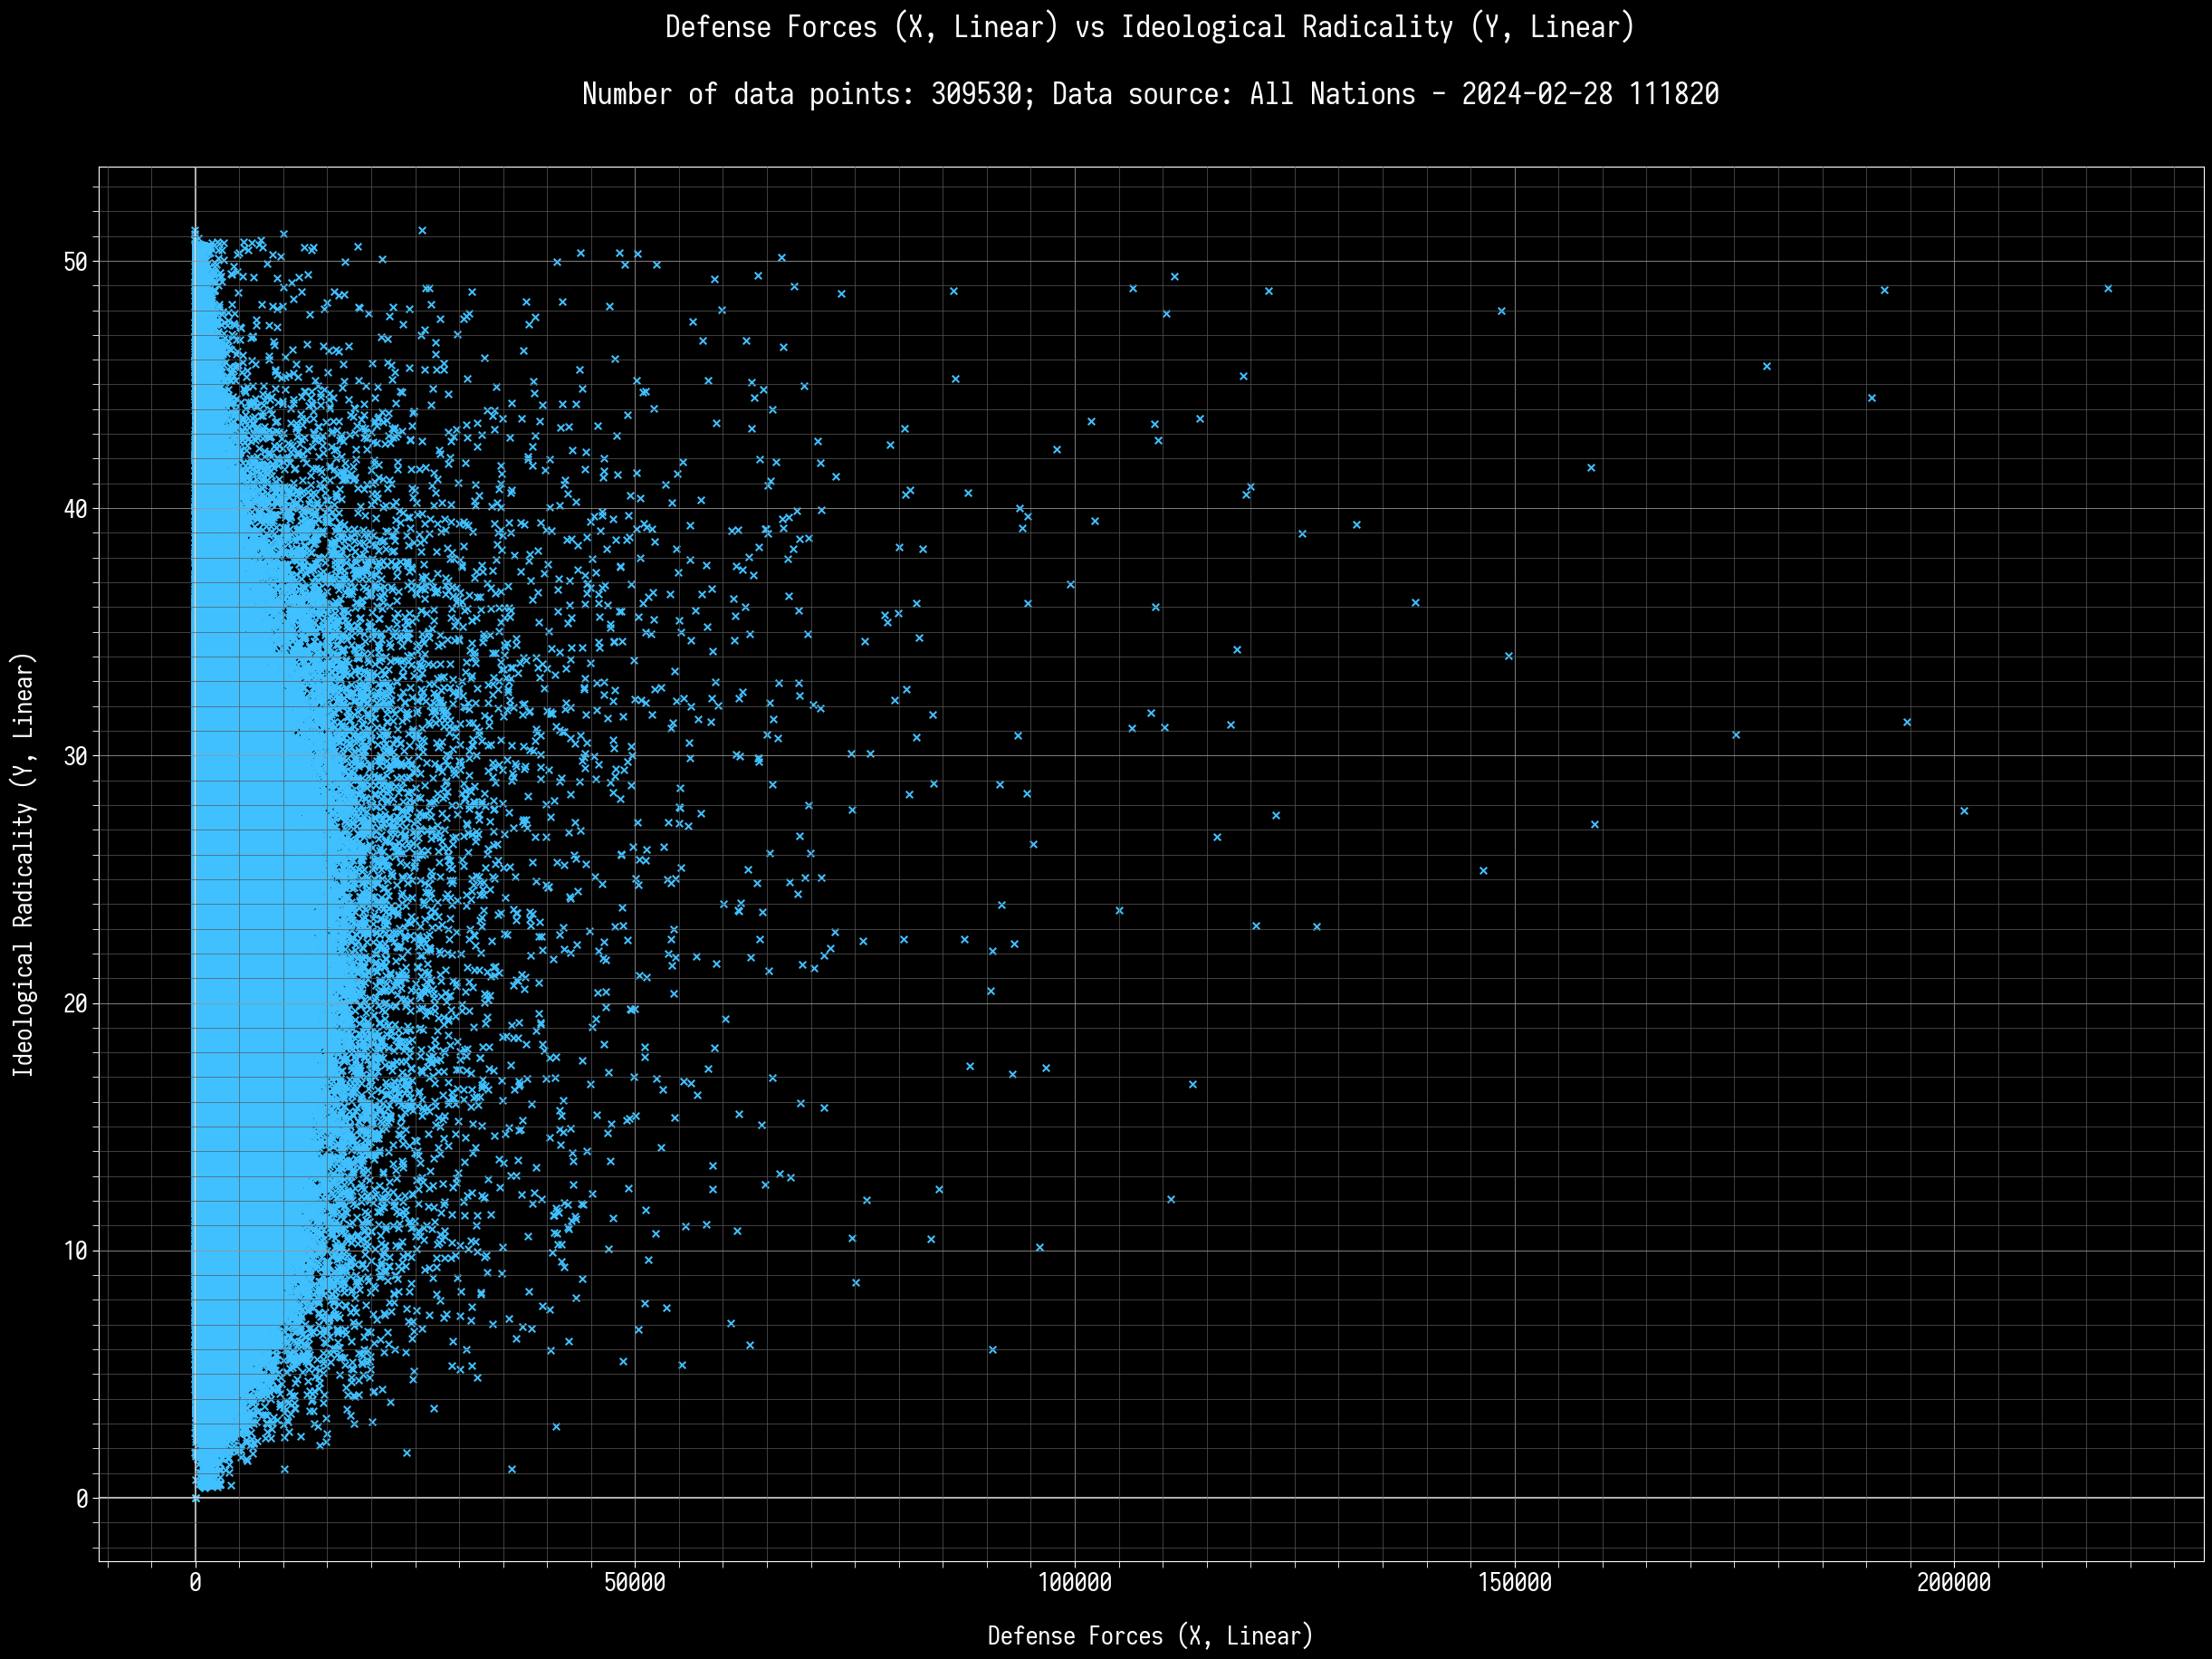

In [8]:
# Global parameters. Mainly for the graphs.

print("Min X:", X.min(),"// Max X:", X.max())
print("Min Y:", Y.min(),"// Max Y:", Y.max())

# XLin/YLin for linear, XLog/YLog for log. 
X_lab = XLin
Y_lab = YLin
symm_log_x = 1
symm_log_y = 0

linthreshx = 10**0
linthreshy = 10**0

single_out = 0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# fig.set_size_inches(20, 13)
fig.set_size_inches(30, 20)
fig.patch.set_color((0/255, 0/255, 0/255))

if X_lab == XLin:
    ax.set_xscale("linear")
else:
    if symm_log_x == 1:
        ax.set_xscale("symlog", base = 10, linthresh = linthreshx)
    else:
        ax.set_xscale("log")
    
if Y_lab == YLin:
    ax.set_yscale("linear")
else:
    if symm_log_y == 1:
        ax.set_yscale("symlog", base = 10, linthresh = linthreshy)
    else:
        ax.set_yscale("log")
    
# ---------------------------------------------------

# Inverts y-axis.
# plt.gca().invert_yaxis()

# ---------------------------------------------------

ax.set_facecolor("black")
ax.set_title(X_lab + " vs " + Y_lab + "\n\n" + "Number of data points: " + str(len(df1)) + "; Data source: " + file_name, pad = 50, color ="white")

ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

# Axis Labels.
ax.set_xlabel(X_lab, color = "white", labelpad = 20)
ax.set_ylabel(Y_lab, color = "white", labelpad = 20)

# Set the 0 lines as white.
ax.axhline(0, color = "white", alpha = 0.75)
ax.axvline(0, color = "white", alpha = 0.75)

# Major and minor grid settings - Color.
grey_major = 150
grey_minor = 90

# Major X and Y axes grid.
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=0.6, c = (grey_major/255, grey_major/255, grey_major/255))
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.6, c = (grey_major/255, grey_major/255, grey_major/255))

ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5, c = (grey_minor/255, grey_minor/255, grey_minor/255))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=0.5, c = (grey_minor/255, grey_minor/255, grey_minor/255))
ax.set_axisbelow(False)

# plt.axhline(y=17889, color='white', linestyle='--', label='Top 1% (As of the time)')

# Providing minor tick marks for both symlog and linear.
if X_lab == XLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshx))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Y_lab == YLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthreshy))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
# Minor labels especially for log axis.
# ax.xaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
# ax.yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
    
# Single out your names in the list. Dims the rest of the data points for better visibility.
if single_out == False:
    ax.scatter(X, Y, color = (64/255, 192/255, 255/255), marker = "x", s = 30)
else:
    ax.scatter(X, Y, color = (100/255, 100/255, 100/255), marker = "x", s = 30)
    ax.scatter(df3.iloc[:,5], df3.iloc[:,6], color = (255/255, 255/255, 0/255), marker = "x", s = 60)
    
# Set limits on graphs.
# ax.set_xlim(xmin = 0, xmax = 3)
# ax.set_ylim(ymin = 54, ymax = 58)

# Formatting for Population or other large numbers. Populations for NS Nations are often in billions.
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1g"))
# ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.0f"))

plt.show()

Min X: -109.59 // Max X: 217497.61
Min Y: 0.0 // Max Y: 51.24
Min Z: 5000000.0 // Max Y: 46664000000.0


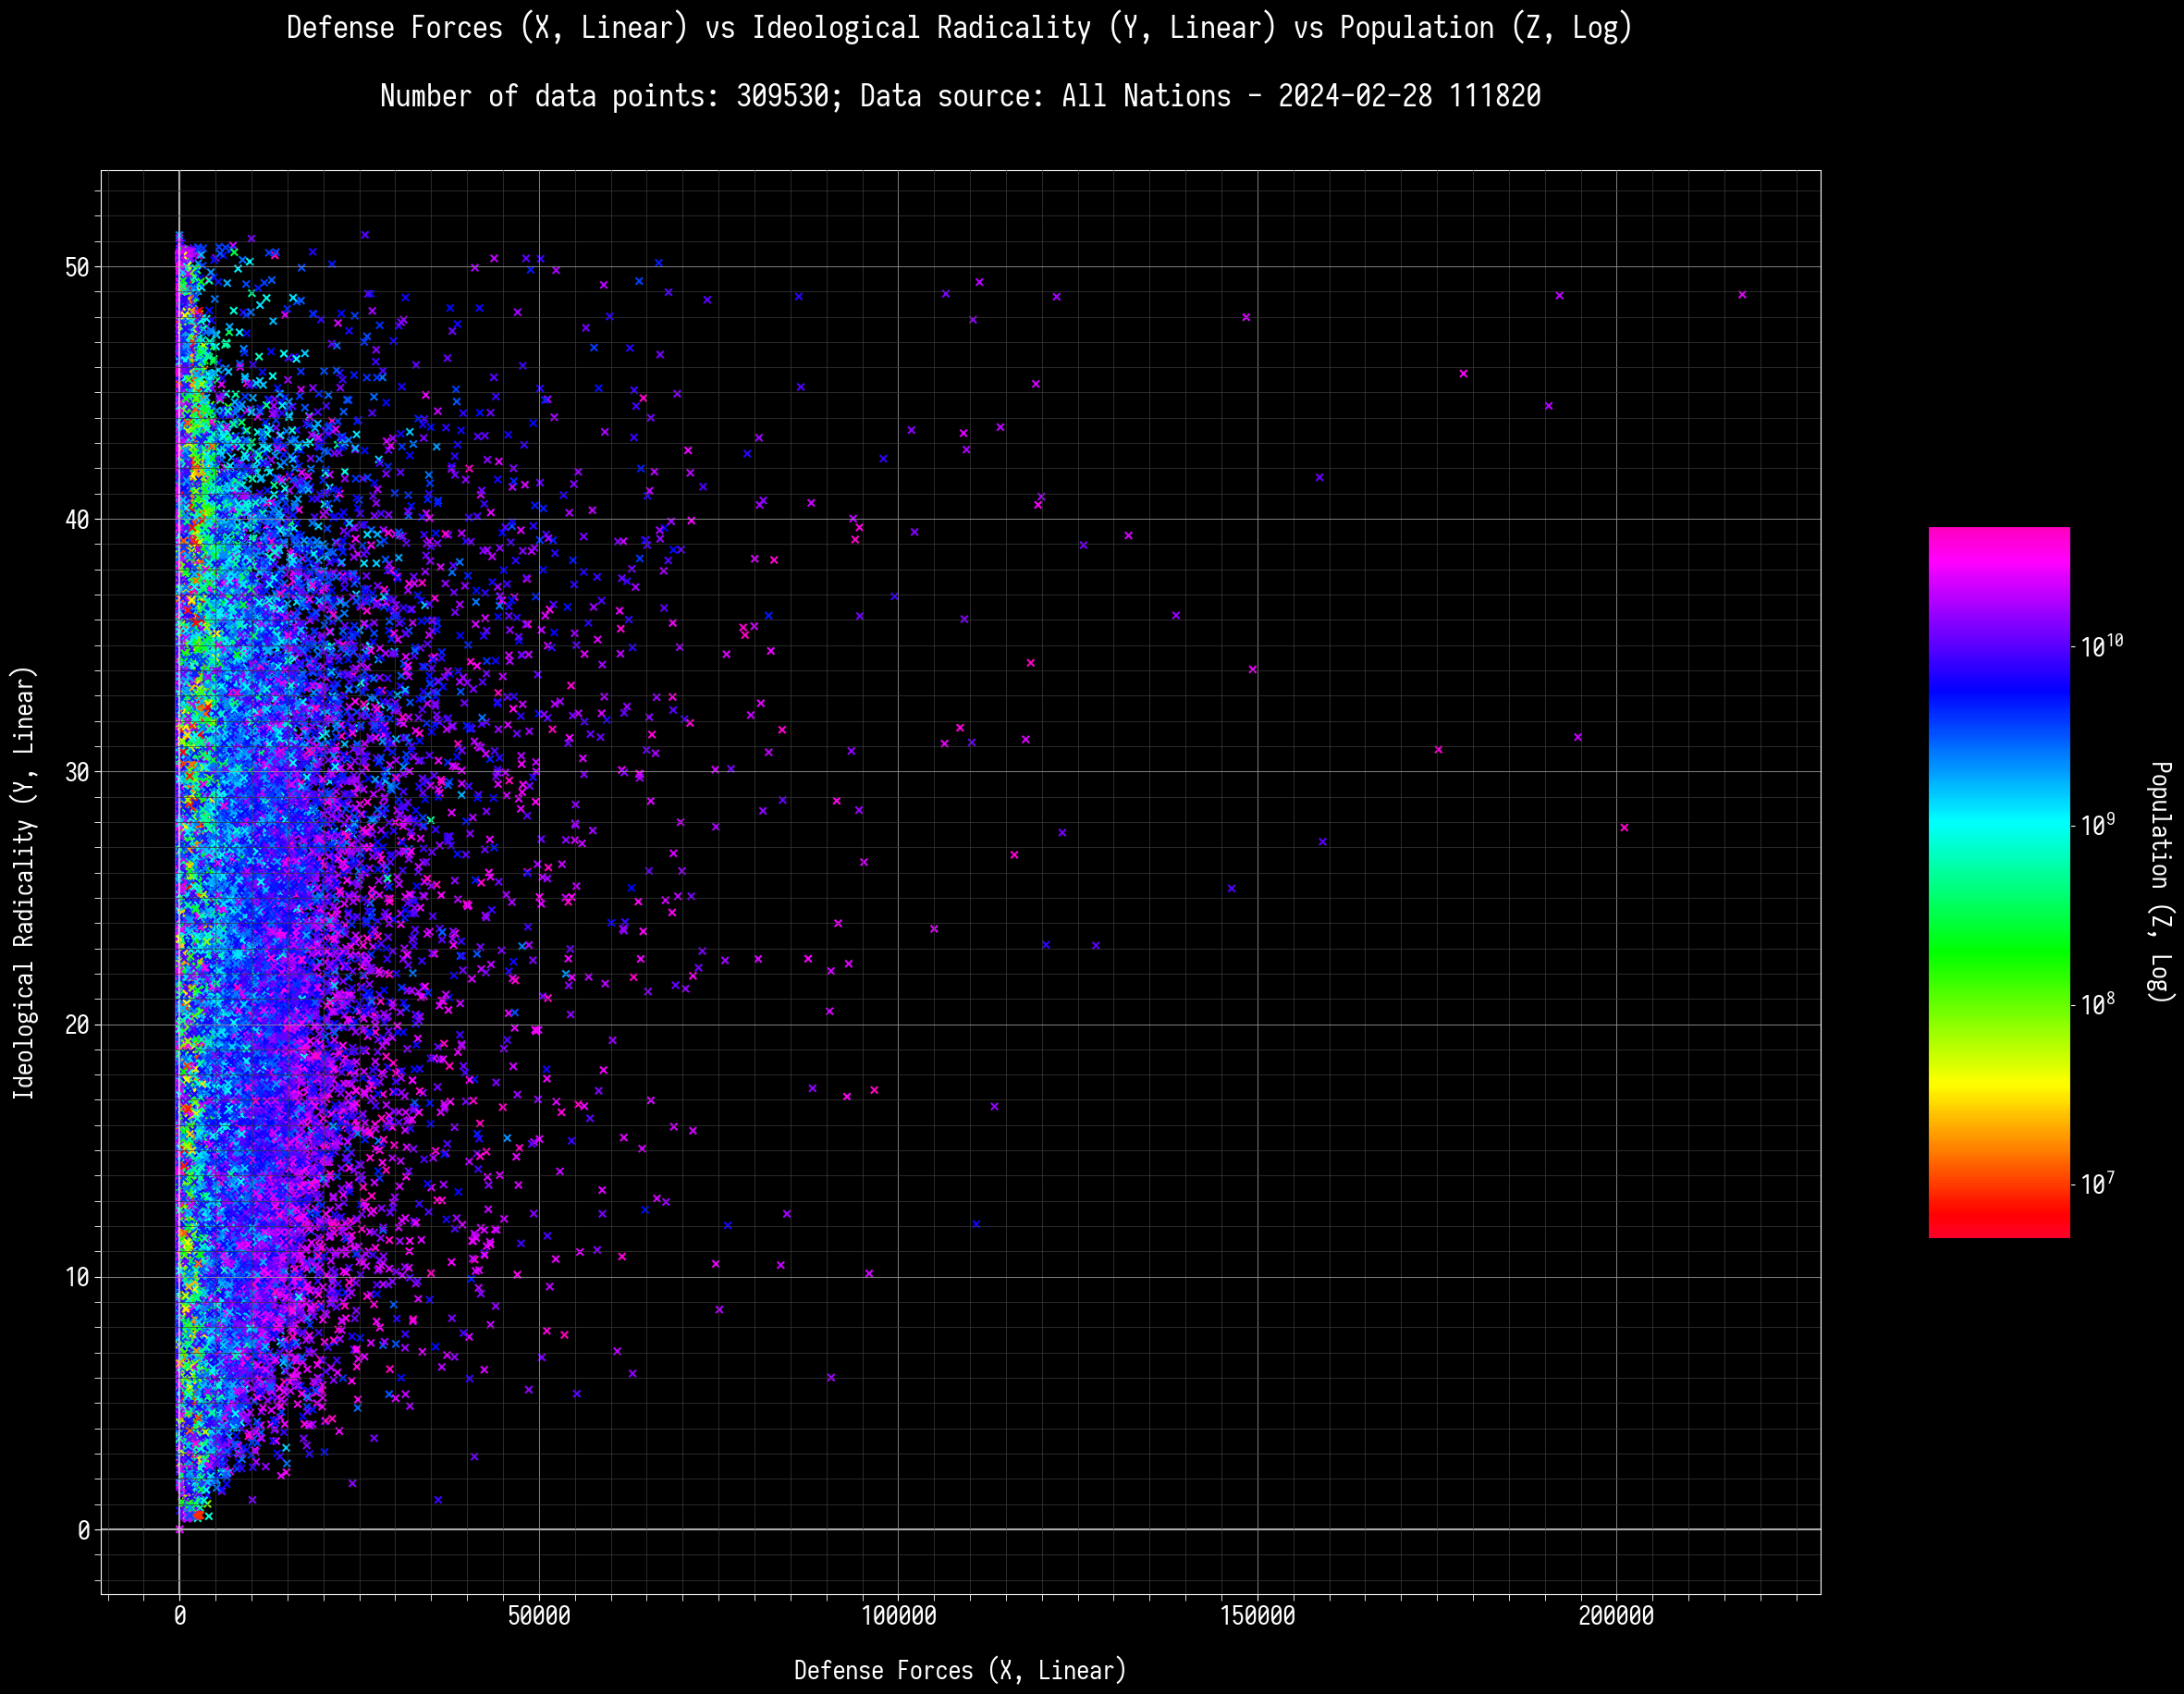

In [9]:
print("Min X:", X.min(),"// Max X:", X.max())
print("Min Y:", Y.min(),"// Max Y:", Y.max())
print("Min Z:", Z.min(),"// Max Y:", Z.max())

# AxisLin for linear, AxisLog for Symmetrical Log.
X_lab = XLin
Y_lab = YLin
Z_lab = ZLog

linthreshx = 10**0
linthreshy = 10**0
linthreshz = 10**0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fig.set_size_inches(30, 20)
# fig.set_size_inches(20, 13)
fig.patch.set_color((0/255, 0/255, 0/255))

if X_lab == XLin:
    ax.set_xscale("linear")
else:
    ax.set_xscale("symlog", base = 10, linthresh = linthreshx)
    # ax.set_xscale("log", base = 10)
    
if Y_lab == YLin:
    ax.set_yscale("linear")
else:
    ax.set_yscale("symlog", base = 10, linthresh = linthreshy)
    # ax.set_yscale("log", base = 10)


cmap = plt.get_cmap('gist_rainbow')
cmap = truncate_colormap(cmap, 0, 1)
# cmap = truncate_colormap(cmap, 0.2, 1)
ax.set_facecolor("black")
ax.set_title(X_lab + " vs " + Y_lab + " vs " + Z_lab +"\n\n" + "Number of data points: " + str(len(df1)) + "; Data source: " + file_name, pad = 50, color ="white")

ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

# Axis Labels.
ax.set_xlabel(X_lab, color = "white", labelpad = 20)
ax.set_ylabel(Y_lab, color = "white", labelpad = 20)

# Set the 0 lines as white.
ax.axhline(0, color = "white", alpha = 0.75)
ax.axvline(0, color = "white", alpha = 0.75)

# Major and minor grid settings - Color.
grey_major = 150
grey_minor = 60

# Major X and Y axes grid.
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=0.6, c = (grey_major/255, grey_major/255, grey_major/255))
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.6, c = (grey_major/255, grey_major/255, grey_major/255))

ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5, c = (grey_minor/255, grey_minor/255, grey_minor/255))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=0.5, c = (grey_minor/255, grey_minor/255, grey_minor/255))
ax.set_axisbelow(False)
    
if Z_lab == ZLin:
    data = ax.scatter(X, Y, c = Z, cmap = cmap, vmin = Z.min(), vmax = Z.max(), marker = "x", s = 30)
else:
    data = ax.scatter(X, Y, c = Z, cmap = cmap, marker = "x", s = 30, norm = colors.SymLogNorm(vmin = Z.min(), vmax = Z.max(), base = 10, linthresh = linthreshz))

cbar = fig.colorbar(data, shrink = 0.5, aspect = 5)
cbar.set_label(Z_lab, labelpad = 40, rotation = 270, color = "white")
cbar.ax.tick_params(color = "white", labelcolor = "white")

# Providing minor tick marks for both symlog and linear.
if X_lab == XLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshx))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Y_lab == YLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthreshy))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))

# Minor labels especially for log axis.
# ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
# ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    
# ---------------------------------------------------

# Set limits on graphs.
# ax.set_xlim(xmin = -25, xmax = 25)
# ax.set_ylim(ymin = -500, ymax = 500)

# Inverts y-axis.
# plt.gca().invert_yaxis()

# Minor labels especially for log axis.
# ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
# ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    
# Scientific Notation Formatting. X-axis, Y-axis, and then Z-axis (cbar).
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.0f"))
# ax.yaxis.set_major_formatter(OOMFormatter(15, "%1.1f"))
# cbar.ax.yaxis.set_major_formatter(OOMFormatter(9, "%1g"))

In [ ]:
# SKIP THIS CHUNK OF CODE IF YOU ARE NOT INTENT ON RUNNING DENSITY. THIS TAKES VERY LONG.

start_time = time.time()

# Calculate the point density. Credit: Joe Kington: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
xy = np.vstack([X, Y])
Freq_XY = gaussian_kde(xy)(xy)

np.savetxt('./xy_%s_%s vs %s.out' % (file_name, x, y), xy, delimiter=',')
np.savetxt('./Freq_xy_%s_%s vs %s.out' % (file_name, x, y), Freq_XY, delimiter=',')

print("Time taken:", time.time() - start_time)

In [10]:
# Reading the contents of xy.out
with open('./xy_%s_%s vs %s.out' % (file_name, x, y), 'r') as file:
    lines = file.readlines()
    x_backup = list(map(float, lines[0].strip().split(',')))
    y_backup = list(map(float, lines[1].strip().split(',')))

# Reading the contents of Freq_xy.out
with open('./Freq_xy_%s_%s vs %s.out' % (file_name, x, y), 'r') as file:
    freq_values = list(map(float, file.readlines()))

# Convert frequency values to numpy array
Freq_XY_backup = np.array(freq_values)

Min X: -109.59 // Max X: 217497.61
Min Y: 0.0 // Max Y: 51.24


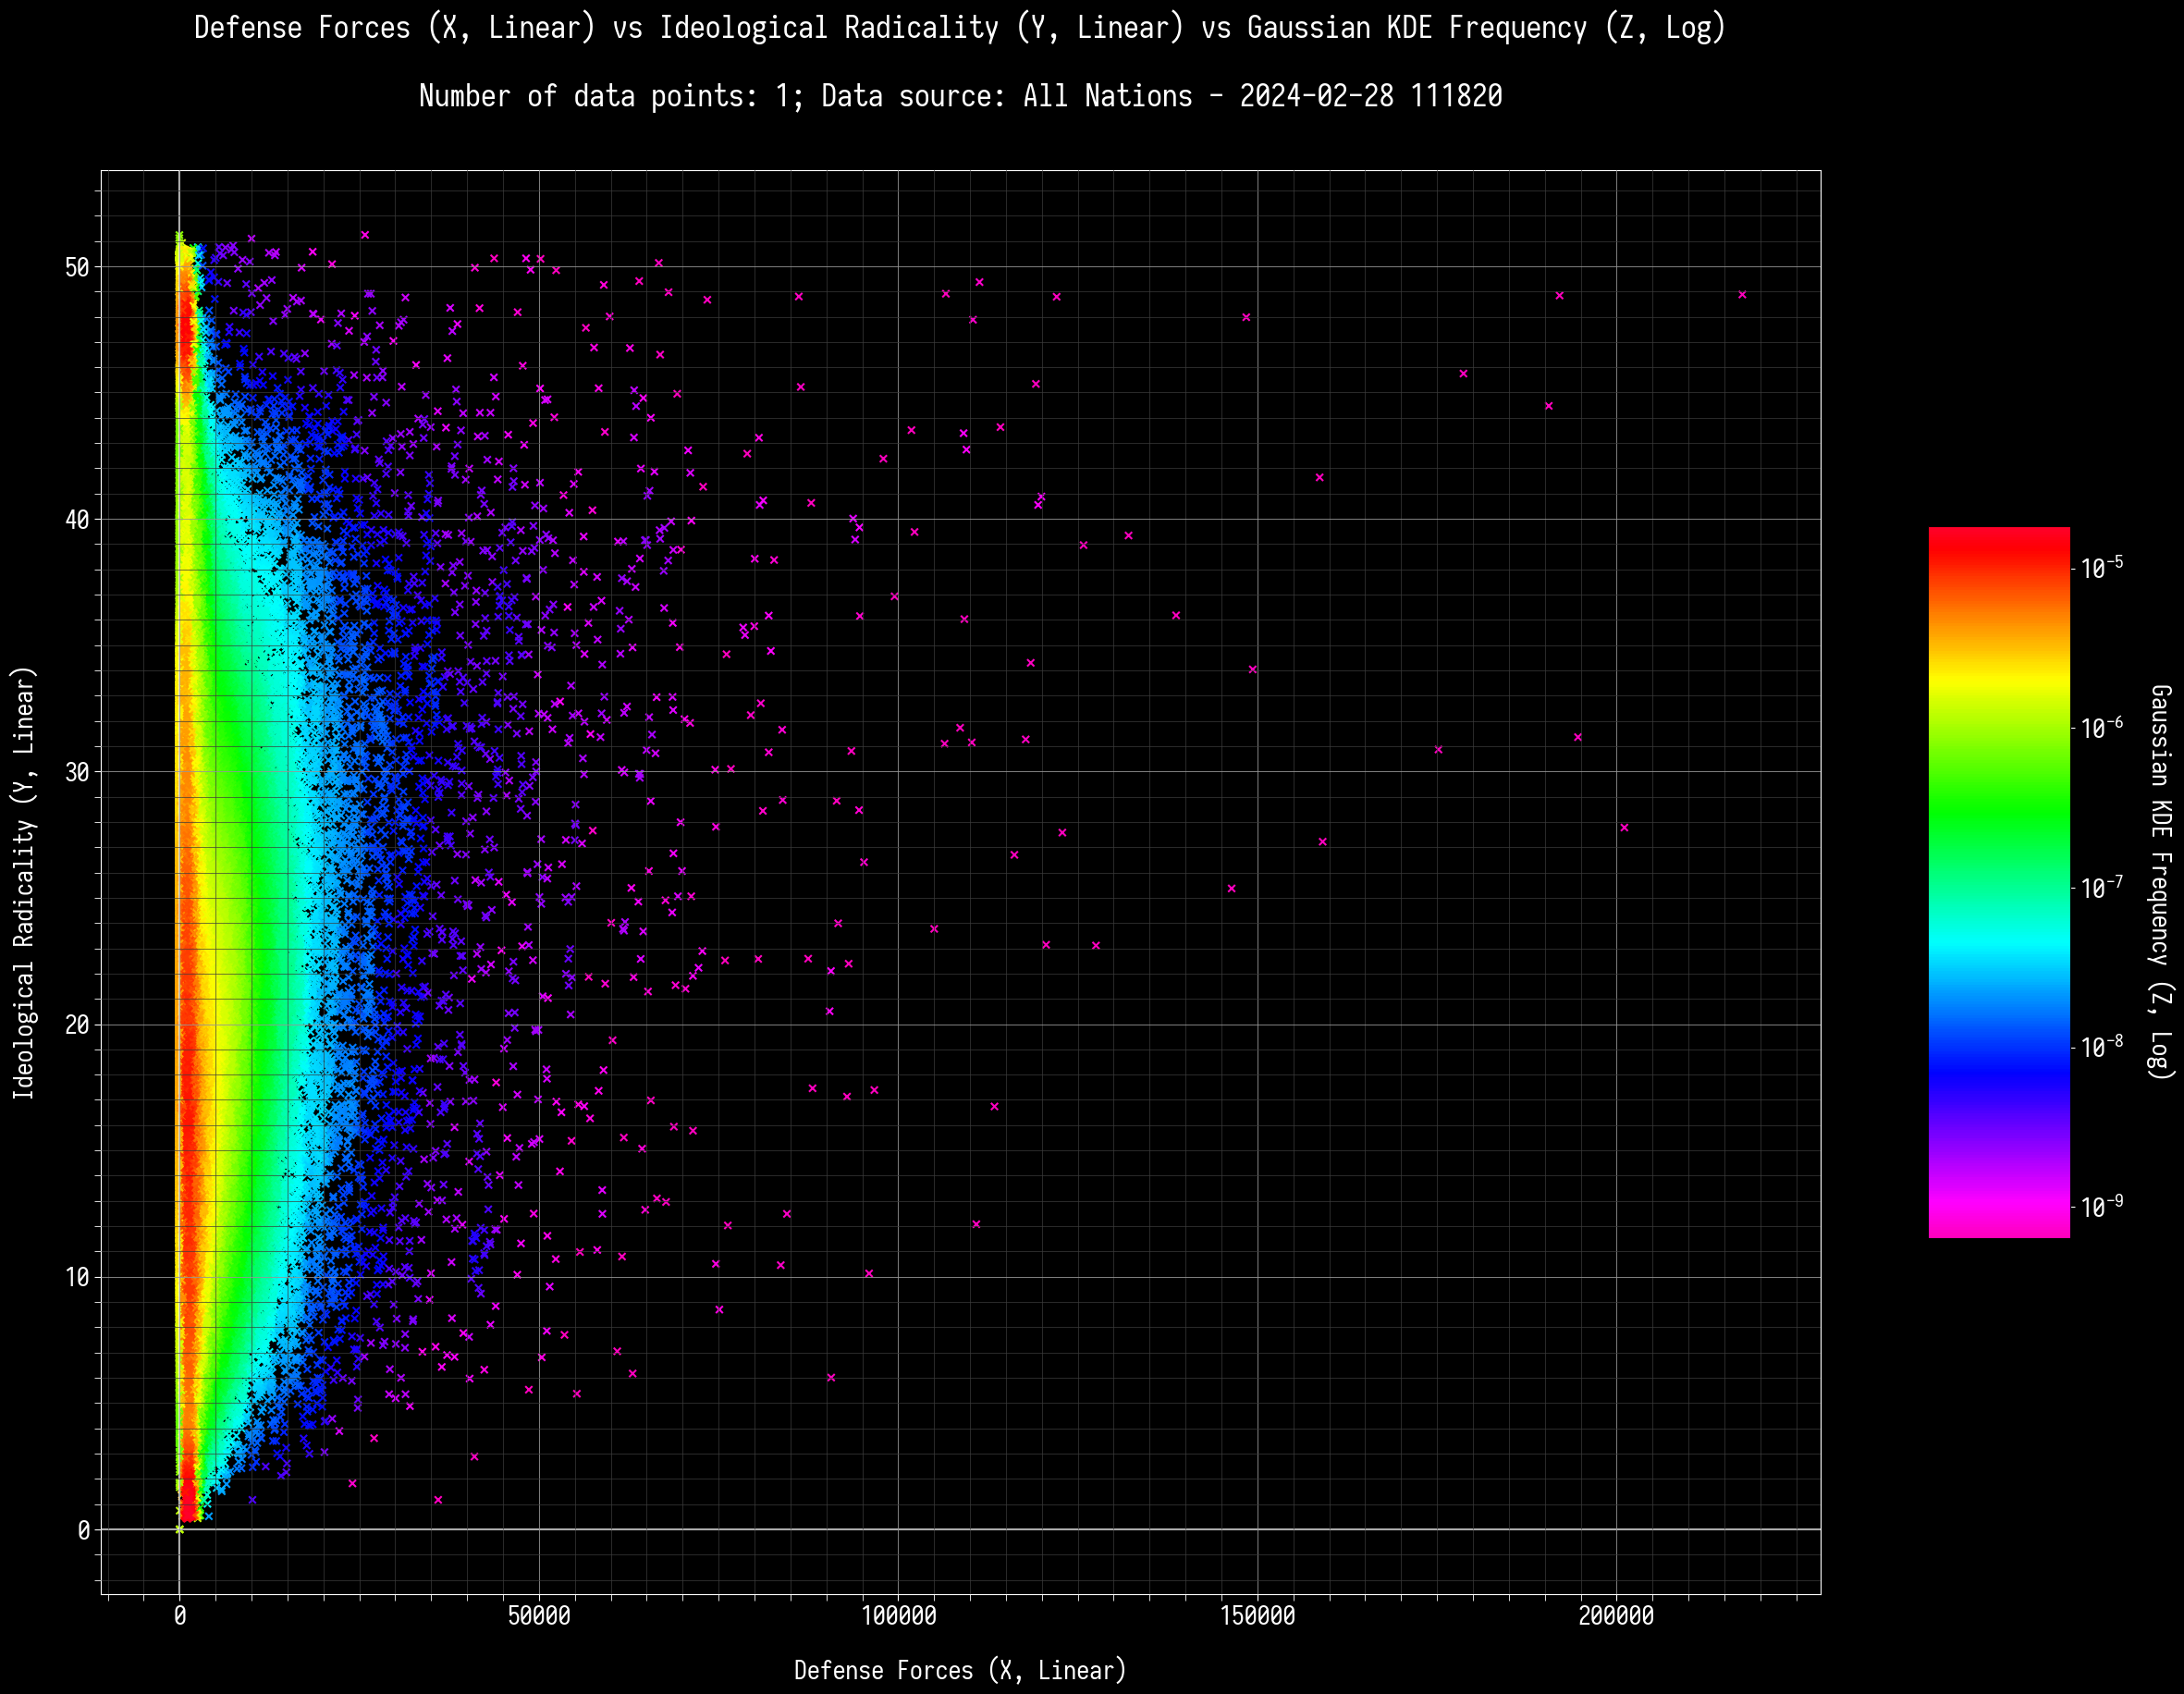

In [11]:
# Gaussian Frequency for Z-axis / Colormap. By default, Red: Most clustered, Pink: Least clustered.

print("Min X:", X.min(),"// Max X:", X.max())
print("Min Y:", Y.min(),"// Max Y:", Y.max())

FreqLin = "Gaussian KDE Frequency (Z, Linear)"
FreqLog = "Gaussian KDE Frequency (Z, Log)"

# AxisLin for linear, AxisLog for Symmetrical Log.
X_lab = XLin
Y_lab = YLin
Freq_lab = FreqLog # Best to keep it at log for the time being. The density function has very differing OOM (Order of Magnitude).

# Choose if you want to use the backed up arrays and values.
backup = 1

linthreshx = 10**0
linthreshy = 10**0

if backup == 1:
    linthreshz = Freq_XY_backup.min()
else:
    linthreshz = Freq_XY.min()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fig.set_size_inches(30, 20)
fig.patch.set_color((0/255, 0/255, 0/255))

if X_lab == XLin:
    ax.set_xscale("linear")
else:
    ax.set_xscale("symlog", base = 10, linthresh = linthreshx)
#     ax.set_xscale("log", base = 10)
    
if Y_lab == YLin:
    ax.set_yscale("linear")
else:
    ax.set_yscale("symlog", base = 10, linthresh = linthreshy)
#     ax.set_yscale("log", base = 10)

cmap = plt.get_cmap('gist_rainbow_r')
cmap = truncate_colormap(cmap, 0, 1)

ax.set_facecolor("black")
ax.set_title(X_lab + " vs " + Y_lab + " vs " + Freq_lab +"\n\n" + "Number of data points: " + str(len(df2)) + "; Data source: " + file_name, pad = 50, color ="white")

ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

# Axis Labels.
ax.set_xlabel(X_lab, color = "white", labelpad = 20)
ax.set_ylabel(Y_lab, color = "white", labelpad = 20)

# Set the 0 lines as white.
ax.axhline(0, color = "white", alpha = 0.75)
ax.axvline(0, color = "white", alpha = 0.75)

# Major and minor grid settings - Color.
grey_major = 150
grey_minor = 60

# Major X and Y axes grid.
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=0.6, c = (grey_major/255, grey_major/255, grey_major/255))
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.6, c = (grey_major/255, grey_major/255, grey_major/255))

ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5, c = (grey_minor/255, grey_minor/255, grey_minor/255))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=0.5, c = (grey_minor/255, grey_minor/255, grey_minor/255))
ax.set_axisbelow(False)
    
if Freq_lab == FreqLin:
    if backup == True:
        data = ax.scatter(x_backup, y_backup, c = Freq_XY_backup, cmap = cmap, vmin = Freq_XY_backup.min(), vmax = Freq_XY_backup.max(), marker = "x", s = 30)
    else:
        data = ax.scatter(X, Y, c = Freq_XY, cmap = cmap, vmin = Freq_XY.min(), vmax = Freq_XY.max(), marker = "x", s = 30)
else:
    if backup == True:
        data = ax.scatter(x_backup, y_backup, c = Freq_XY_backup, cmap = cmap, marker = "x", s = 30, norm = colors.SymLogNorm(vmin = Freq_XY_backup.min(), vmax = Freq_XY_backup.max(), linthresh = linthreshz))
    else:
        data = ax.scatter(X, Y, c = Freq_XY, cmap = cmap, marker = "x", s = 30, norm = colors.SymLogNorm(vmin = Freq_XY.min(), vmax = Freq_XY.max(), linthresh = linthreshz))

cbar = fig.colorbar(data, shrink = 0.5, aspect = 5)
cbar.set_label(Freq_lab, labelpad = 40, rotation = 270, color = "white")
cbar.ax.tick_params(color = "white", labelcolor = "white")

# Providing minor tick marks for both symlog and linear.
if X_lab == XLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshx))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Y_lab == YLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthreshy))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))

# ---------------------------------------------------

# Minor labels especially for log axis.
# ax.xaxis.set_minor_formatter(FormatStrFormatter("%.2f"))
# ax.tick_params(axis='x', which='minor', labelsize=16, rotation=90)
# ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
# ax.tick_params(axis='y', which='minor', labelsize=16, rotation=90)

# Set limits on graphs.
# ax.set_xlim(xmin = -1000, xmax = 5000)
# ax.set_ylim(ymin = 0, ymax = 250)

# Scientific Notation Formatting. X-axis, Y-axis, and then Z-axis (cbar).
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
# ax.yaxis.set_major_formatter(OOMFormatter(15, "%1.0f"))
# cbar.ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.0f"))

# Inverts y-axis.
# plt.gca().invert_yaxis()

In [12]:
# For filtering. Contains all variables. Prepares top and bottom values.

bottom_value_x = (X.sort_values(ascending = False).reset_index(drop = True))[int(len(X) * 0.90)]
top_value_x = (X.sort_values(ascending = False).reset_index(drop = True))[int(len(X) * 0.10)]

bottom_value_y = (Y.sort_values(ascending = False).reset_index(drop = True))[int(len(Y) * 0.90)]
top_value_y = (Y.sort_values(ascending = False).reset_index(drop = True))[int(len(Y) * 0.10)]

bottom_value_z = (Z.sort_values(ascending = False).reset_index(drop = True))[int(len(Z) * 0.90)]
top_value_z = (Z.sort_values(ascending = False).reset_index(drop = True))[int(len(Z) * 0.10)]

bottom_value_population = (df1["Population of Nation"].sort_values(ascending = False).reset_index(drop = True))[int(len(df1["Population of Nation"]) * 0.90)]
top_value_population = (df1["Population of Nation"].sort_values(ascending = False).reset_index(drop = True))[int(len(df1["Population of Nation"]) * 0.10)]

bottom_value_issues = 100
top_value_issues = 1000

x_value = x + " (x)"
y_value = y + " (y)"
z_value = z + " (z)"
pop_value = "Population of Nation"
issue_value = "Number of Issues Answered"

In [13]:
# For two variables - X and Y. Z-independent.
# Should I use the classes here? Meh.

# --------------------------------------------------------------------------------------------------
# Find the min and max.

print("X max and Y max:", len(df1[(X == X.max()) & (Y == Y.max())]))
print("X min and Y min:", len(df1[(X == X.min()) & (Y == Y.min())]))
print("X max and Y min:", len(df1[(X == X.max()) & (Y == Y.min())]))
print("X min and Y max:", len(df1[(X == X.min()) & (Y == Y.max())]))

print("\n")

print("X max:", len(df1[(X == X.max())]))
print("X min:", len(df1[(X == X.min())]))
print("Y max:", len(df1[(Y == Y.max())]))
print("Y min:", len(df1[(Y == Y.min())]))

print("\n")

# --------------------------------------------------------------------------------------------------
# Only for X and Y.

Filter1 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y)] # High X, High Y.
Filter2 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y)] # Low X, Low Y.
Filter3 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < top_value_y)] # High x, Low y
Filter4 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > bottom_value_y)] # Low x, High y.

format_string = "High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       len(Filter1), str(len(df1))
))

format_string = "Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       len(Filter2), str(len(df1))
))

format_string = "High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       len(Filter3), str(len(df1))
))

format_string = "Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       len(Filter4), str(len(df1))
))

print("\n")

# --------------------------------------------------------------------------------------------------
# X and Y, together with population.

Filter5 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[pop_value] > top_value_population)] # Hi X, Hi Y, Hi Pop
Filter6 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[pop_value] < bottom_value_population)] # Hi X, Hi Y, Lo Pop

Filter7 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[pop_value] > top_value_population)] # Lo X, Lo Y, Hi Pop
Filter8 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[pop_value] < bottom_value_population)] # Lo X, Lo Y, Lo Pop

Filter9 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[pop_value] > top_value_population)] # Hi X, Lo Y, Hi Pop
Filter10 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[pop_value] < bottom_value_population)] # Hi X, Lo Y, Lo Pop

Filter11 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[pop_value] > top_value_population)] # Lo X, Hi Y, Hi Pop
Filter12 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[pop_value] < bottom_value_population)] # Lo X, Hi Y, Lo Pop

format_string = "High %s (> %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x), 
                       string.capwords(y), '{:,.2f}'.format(top_value_y), 
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population), 
                       len(Filter5), str(len(df1))))

format_string = "High %s (> %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x), 
                       string.capwords(y), '{:,.2f}'.format(top_value_y), 
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population), 
                       len(Filter6), str(len(df1))))

format_string = "Low %s (< %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x), 
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y), 
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population), 
                       len(Filter7), str(len(df1))))

format_string = "Low %s (< %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x), 
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y), 
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population), 
                       len(Filter8), str(len(df1))))

format_string = "High %s (> %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x), 
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y), 
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population), 
                       len(Filter9), str(len(df1))))

format_string = "High %s (> %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x), 
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y), 
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population), 
                       len(Filter10), str(len(df1))))

format_string = "Low %s (< %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x), 
                       string.capwords(y), '{:,.2f}'.format(top_value_y), 
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population), 
                       len(Filter11), str(len(df1))))

format_string = "Low %s (< %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x), 
                       string.capwords(y), '{:,.2f}'.format(top_value_y), 
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population), 
                       len(Filter12), str(len(df1))))

print("\n")

# --------------------------------------------------------------------------------------------------
# X and Y, together with Number of Issues Answered.

Filter13 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[issue_value] > top_value_issues)] # Hi X, Hi Y, Hi Issue Answered
Filter14 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[issue_value] < bottom_value_issues)] # Hi X, Hi Y, Lo Issue Answered

Filter15 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[issue_value] > top_value_issues)] # Lo X, Lo Y, Hi Issue Answered
Filter16 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[issue_value] < bottom_value_issues)] # Lo X, Lo Y, Lo Issue Answered

Filter17 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[issue_value] > top_value_issues)] # Hi X, Lo Y, Hi Issue Answered
Filter18 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[issue_value] < bottom_value_issues)] # Hi X, Lo Y, Lo Issue Answered

Filter19 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[issue_value] > top_value_issues)] # Lo X, Hi Y, Hi Issue Answered
Filter20 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[issue_value] < bottom_value_issues)] # Lo X, Hi Y, Lo Issue Answered

format_string = "High %s (> %s), %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x), 
                       string.capwords(y), '{:,.2f}'.format(top_value_y), 
                       string.capwords(issue_value), '{:,.0f}'.format(top_value_issues), 
                       len(Filter13), str(len(df1))))

format_string = "High %s (> %s), %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x), 
                       string.capwords(y), '{:,.2f}'.format(top_value_y), 
                       string.capwords(issue_value), '{:,.0f}'.format(bottom_value_issues), 
                       len(Filter14), str(len(df1))))

format_string = "Low %s (< %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x), 
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y), 
                       string.capwords(issue_value), '{:,.0f}'.format(top_value_issues), 
                       len(Filter15), str(len(df1))))

format_string = "Low %s (< %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x), 
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y), 
                       string.capwords(issue_value), '{:,.0f}'.format(bottom_value_issues), 
                       len(Filter16), str(len(df1))))

format_string = "High %s (> %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x), 
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y), 
                       string.capwords(issue_value), '{:,.0f}'.format(top_value_issues), 
                       len(Filter17), str(len(df1))))

format_string = "High %s (> %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x), 
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y), 
                       string.capwords(issue_value), '{:,.0f}'.format(bottom_value_issues), 
                       len(Filter18), str(len(df1))))

format_string = "Low %s (< %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x), 
                       string.capwords(y), '{:,.2f}'.format(top_value_y), 
                       string.capwords(issue_value), '{:,.0f}'.format(top_value_issues), 
                       len(Filter19), str(len(df1))))

format_string = "Low %s (< %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x), 
                       string.capwords(y), '{:,.2f}'.format(top_value_y), 
                       string.capwords(issue_value), '{:,.0f}'.format(bottom_value_issues), 
                       len(Filter20), str(len(df1))))

print("\n")

# --------------------------------------------------------------------------------------------------
# Table for X and Y min and max.

df1[(X == X.min()) | (X == X.max()) | (Y == Y.min()) | (Y == Y.max())].style.format({                          
# df1[(Y == Y.min()) | (Y == Y.max())].style.format({              
                
    df1.columns[2] : '{:,.0f}',  
    df1.columns[3] : '{:,.0f}', 

     df1.columns[4] : '{:,.0f}',
     df1.columns[5] : '{:,.2f}',
     df1.columns[6] : '{:,.2f}', 
#      df1.columns[7] : '{:,.2f}',
})

X max and Y max: 0
X min and Y min: 0
X max and Y min: 0
X min and Y max: 0


X max: 1
X min: 1
Y max: 1
Y min: 3


High Defense Forces (> 6,304.05), High Ideological Radicality (> 39.66): 711 nations out of 309530.
Low Defense Forces (< 555.50), Low Ideological Radicality (< 3.17): 42 nations out of 309530.
High Defense Forces (> 6,304.05), Low Ideological Radicality (< 3.17): 30239 nations out of 309530.
Low Defense Forces (< 555.50), High Ideological Radicality (> 39.66): 30910 nations out of 309530.


High Defense Forces (> 6,304.05), High Ideological Radicality (> 39.66), High Population (> 13,212,000,000): 120 nations out of 309530.
High Defense Forces (> 6,304.05), High Ideological Radicality (> 39.66), Low Population (< 68,000,000): 0 nations out of 309530.
Low Defense Forces (< 555.50), Low Ideological Radicality (< 3.17), High Population (> 13,212,000,000): 9 nations out of 309530.
Low Defense Forces (< 555.50), Low Ideological Radicality (< 3.17), Low Population (< 68,000,00

,Short Name of the Nation (no pretitle),Region Name,Population of Nation,Number of Issues Answered,defense forces (x),ideological radicality (y),population (z)
53513,average_nation-3,Test22,"2,395,000,000",9,0,0.00,"2,395,000,000.00"
58812,bedetopia,Bedetopian Network,"24,701,000,000","5,176","217,498",48.88,"24,701,000,000.00"
99325,random_card_farmer_143,Balder,"8,000,000",0,0,0.00,"8,000,000.00"
106439,aryax,10000 Islands,"9,434,000,000","3,085","25,804",51.24,"9,434,000,000.00"
126015,upper-wisconsin,The Imperial City,"20,685,000,000",3,0,0.00,"20,685,000,000.00"
247726,blogotopia,10000 Islands,"41,605,000,000","12,389",-110,11.70,"41,605,000,000.00"


In [14]:
# For three variables - X, Y, and Z. Z-dependent.
# Good grief.

# --------------------------------------------------------------------------------------------------
# Find the min and max.

print("X max and Y max and Z max:", len(df1[(X == X.max()) & (Y == Y.max()) & (Z == Z.max())]))
print("X max and Y max and Z min:", len(df1[(X == X.max()) & (Y == Y.max()) & (Z == Z.min())]))

print("X min and Y min and Z max:", len(df1[(X == X.min()) & (Y == Y.min()) & (Z == Z.max())]))
print("X min and Y min and Z min:", len(df1[(X == X.min()) & (Y == Y.min()) & (Z == Z.min())]))

print("X max and Y min and Z max:", len(df1[(X == X.max()) & (Y == Y.min()) & (Z == Z.max())]))
print("X max and Y min and Z min:", len(df1[(X == X.max()) & (Y == Y.min()) & (Z == Z.min())]))

print("X min and Y max and Z max:", len(df1[(X == X.min()) & (Y == Y.max()) & (Z == Z.max())]))
print("X min and Y max and Z min:", len(df1[(X == X.min()) & (Y == Y.max()) & (Z == Z.min())]))

print("\n")

print("X max:", len(df1[(X == X.max())]))
print("X min:", len(df1[(X == X.min())]))

print("Y max:", len(df1[(Y == Y.max())]))
print("Y min:", len(df1[(Y == Y.min())]))

print("Z max:", len(df1[(Z == Z.max())]))
print("Z min:", len(df1[(Z == Z.min())]))

print("\n")

# --------------------------------------------------------------------------------------------------
# X, Y, and Z.

Filter21 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] > top_value_z)] # Hi X, Hi Y, Hi Z
Filter22 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] < bottom_value_z)] # Hi X, Hi Y, Lo Z
Filter23 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] > top_value_z)] # Lo X, Lo Y, Hi Z
Filter24 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] < bottom_value_z)] # Lo X, Lo Y, Lo Z
Filter25 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] > top_value_z)] # Hi X, Lo Y, Hi Z
Filter26 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] < bottom_value_z)] # Hi X, Lo Y, Lo Z
Filter27 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] > top_value_z)] # Lo X, Hi Y, Hi Z
Filter28 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] < bottom_value_z)] # Lo X, Hi Y, Lo Z

format_string = "High %s (> %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       len(Filter21), str(len(df1))
))

format_string = "High %s (> %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       len(Filter22), str(len(df1))
))

format_string = "Low %s (< %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       len(Filter23), str(len(df1))
))

format_string = "Low %s (< %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       len(Filter24), str(len(df1))
))

format_string = "High %s (> %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       len(Filter25), str(len(df1))
))

format_string = "High %s (> %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       len(Filter26), str(len(df1))
))

format_string = "Low %s (< %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       len(Filter27), str(len(df1))
))

format_string = "Low %s (< %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       len(Filter28), str(len(df1))
))
    
print("\n")

# --------------------------------------------------------------------------------------------------
# X, Y, Z, together with Population.
# There's probably an easier/smarter/less messy way to this, but screw it.

Filter29 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] > top_value_z) & (df1[pop_value] > top_value_population)] # Hi X, Hi Y, Hi Z, Hi Pop
Filter30 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] > top_value_z) & (df1[pop_value] < bottom_value_population)] # Hi X, Hi Y, Hi Z, Lo Pop

Filter31 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] < bottom_value_z) & (df1[pop_value] > top_value_population)] # Hi X, Hi Y, Lo Z, Hi Pop
Filter32 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] < bottom_value_z) & (df1[pop_value] < bottom_value_population)] # Hi X, Hi Y, Lo Z, Lo Pop

Filter33 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] > top_value_z) & (df1[pop_value] > top_value_population)] # Lo X, Lo Y, Hi Z, Hi Pop
Filter34 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] > top_value_z) & (df1[pop_value] < bottom_value_population)] # Lo X, Lo Y, Hi Z, Lo Pop

Filter35 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] < bottom_value_z) & (df1[pop_value] > top_value_population)] # Lo X, Lo Y, Lo Z, Hi Pop
Filter36 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] < bottom_value_z) & (df1[pop_value] < bottom_value_population)] # Lo X, Lo Y, Lo Z, Lo Pop

Filter37 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] > top_value_z) & (df1[pop_value] > top_value_population)] # Hi X, Lo Y, Hi Z, Hi Pop
Filter38 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] > top_value_z) & (df1[pop_value] < bottom_value_population)] # Hi X, Lo Y, Hi Z, Lo Pop

Filter39 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] < bottom_value_z) & (df1[pop_value] > top_value_population)] # Hi X, Lo Y, Lo Z, Hi Pop
Filter40 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] < bottom_value_z) & (df1[pop_value] < bottom_value_population)] # Hi X, Lo Y, Lo Z, Lo Pop

Filter41 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] > top_value_z) & (df1[pop_value] > top_value_population)] # Lo X, Hi Y, Hi Z, Hi Pop
Filter42 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] > top_value_z) & (df1[pop_value] < bottom_value_population)] # Lo X, Hi Y, Hi Z, Lo Pop

Filter43 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] < bottom_value_z) & (df1[pop_value] > top_value_population)] # Lo X, Hi Y, Lo Z, Hi Pop
Filter44 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] < bottom_value_z) & (df1[pop_value] < bottom_value_population)] # Lo X, Hi Y, Lo Z, Lo Pop

format_string = "High %s (> %s), High %s (> %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population),
                       len(Filter29), str(len(df1))
))

format_string = "High %s (> %s), High %s (> %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population),
                       len(Filter30), str(len(df1))
))

format_string = "High %s (> %s), High %s (> %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population),
                       len(Filter31), str(len(df1))
))

format_string = "High %s (> %s), High %s (> %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population),
                       len(Filter32), str(len(df1))
))

format_string = "Low %s (< %s), Low %s (< %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population),
                       len(Filter33), str(len(df1))
))

format_string = "Low %s (< %s), Low %s (< %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population),
                       len(Filter34), str(len(df1))
))

format_string = "Low %s (< %s), Low %s (< %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population),
                       len(Filter35), str(len(df1))
))

format_string = "Low %s (< %s), Low %s (< %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population),
                       len(Filter36), str(len(df1))
))

format_string = "High %s (> %s), Low %s (< %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population),
                       len(Filter37), str(len(df1))
))

format_string = "High %s (> %s), Low %s (< %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population),
                       len(Filter38), str(len(df1))
))

format_string = "High %s (> %s), Low %s (< %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population),
                       len(Filter39), str(len(df1))
))

format_string = "High %s (> %s), Low %s (< %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population),
                       len(Filter40), str(len(df1))
))

format_string = "Low %s (< %s), High %s (> %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population),
                       len(Filter41), str(len(df1))
))

format_string = "Low %s (< %s), High %s (> %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population),
                       len(Filter42), str(len(df1))
))

format_string = "Low %s (< %s), High %s (> %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(top_value_population),
                       len(Filter43), str(len(df1))
))

format_string = "Low %s (< %s), High %s (> %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Population"), '{:,.0f}'.format(bottom_value_population),
                       len(Filter44), str(len(df1))
))

print("\n")

# --------------------------------------------------------------------------------------------------
# X, Y, Z, together with Issues Answered.
# There's probably an easier/smarter/less messy way to this, but screw it.

Filter45 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] > top_value_z) & (df1[issue_value] > top_value_issues)] # Hi X, Hi Y, Hi Z, Hi Issue Answered
Filter46 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] > top_value_z) & (df1[issue_value] < bottom_value_issues)] # Hi X, Hi Y, Hi Z, Lo Issue Answered

Filter47 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] < bottom_value_z) & (df1[issue_value] > top_value_issues)] # Hi X, Hi Y, Lo Z, Hi Issue Answered
Filter48 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] < bottom_value_z) & (df1[issue_value] < bottom_value_issues)] # Hi X, Hi Y, Lo Z, Lo Issue Answered

Filter49 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] > top_value_z) & (df1[issue_value] > top_value_issues)] # Lo X, Lo Y, Hi Z, Hi Issue Answered
Filter50 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] > top_value_z) & (df1[issue_value] < bottom_value_issues)] # Lo X, Lo Y, Hi Z, Lo Issue Answered

Filter51 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] < bottom_value_z) & (df1[issue_value] > top_value_issues)] # Lo X, Lo Y, Lo Z, Hi Issue Answer
Filter52 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] < bottom_value_z) & (df1[issue_value] < bottom_value_issues)] # Lo X, Lo Y, Lo Z, Lo Issue Answered

Filter53 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] > top_value_z) & (df1[issue_value] > top_value_issues)] # Hi X, Lo Y, Hi Z, Hi Issue Answered
Filter54 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] > top_value_z) & (df1[issue_value] < bottom_value_issues)] # Hi X, Lo Y, Hi Z, Lo Issue Answered

Filter55 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] < bottom_value_z) & (df1[issue_value] > top_value_issues)] # Hi X, Lo Y, Lo Z, Hi Issue Answered
Filter56 =  df1[(df1[x_value] > top_value_x) & (df1[y_value] < bottom_value_y) & (df1[z_value] < bottom_value_z) & (df1[issue_value] < bottom_value_issues)] # Hi X, Lo Y, Lo Z, Lo Issue Answered

Filter57 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] > top_value_z) & (df1[issue_value] > top_value_issues)] # Lo X, Hi Y, Hi Z, Hi Issue Answered
Filter58 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] > top_value_z) & (df1[issue_value] < bottom_value_issues)] # Lo X, Hi Y, Hi Z, Lo Issue Answered

Filter59 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] < bottom_value_z) & (df1[issue_value] > top_value_issues)] # Lo X, Hi Y, Lo Z, Hi Issue Answered
Filter60 =  df1[(df1[x_value] < bottom_value_x) & (df1[y_value] > top_value_y) & (df1[z_value] < bottom_value_z) & (df1[issue_value] < bottom_value_issues)] # Lo X, Hi Y, Lo Z, Lo Issue Answered

format_string = "High %s (> %s), High %s (> %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(top_value_issues),
                       len(Filter45), str(len(df1))
))

format_string = "High %s (> %s), High %s (> %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(bottom_value_issues),
                       len(Filter46), str(len(df1))
))

format_string = "High %s (> %s), High %s (> %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(top_value_issues),
                       len(Filter47), str(len(df1))
))

format_string = "High %s (> %s), High %s (> %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(bottom_value_issues),
                       len(Filter48), str(len(df1))
))

format_string = "Low %s (< %s), Low %s (< %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(top_value_issues),
                       len(Filter49), str(len(df1))
))

format_string = "Low %s (< %s), Low %s (< %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(bottom_value_issues),
                       len(Filter50), str(len(df1))
))

format_string = "Low %s (< %s), Low %s (< %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(top_value_issues),
                       len(Filter51), str(len(df1))
))

format_string = "Low %s (< %s), Low %s (< %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(bottom_value_issues),
                       len(Filter52), str(len(df1))
))

format_string = "High %s (> %s), Low %s (< %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(top_value_issues),
                       len(Filter53), str(len(df1))
))

format_string = "High %s (> %s), Low %s (< %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(bottom_value_issues),
                       len(Filter54), str(len(df1))
))

format_string = "High %s (> %s), Low %s (< %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(top_value_issues),
                       len(Filter55), str(len(df1))
))

format_string = "High %s (> %s), Low %s (< %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(top_value_x),
                       string.capwords(y), '{:,.2f}'.format(bottom_value_y),
                       string.capwords(z), '{:,.2f}'.format(bottom_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(bottom_value_issues),
                       len(Filter56), str(len(df1))
))

format_string = "Low %s (< %s), High %s (> %s), High %s (> %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(top_value_issues),
                       len(Filter57), str(len(df1))
))

format_string = "Low %s (< %s), High %s (> %s), High %s (> %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(bottom_value_issues),
                       len(Filter58), str(len(df1))
))

format_string = "Low %s (< %s), High %s (> %s), Low %s (< %s), High %s (> %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(top_value_issues),
                       len(Filter59), str(len(df1))
))

format_string = "Low %s (< %s), High %s (> %s), Low %s (< %s), Low %s (< %s): %d nations out of %s."
print(format_string % (string.capwords(x), '{:,.2f}'.format(bottom_value_x),
                       string.capwords(y), '{:,.2f}'.format(top_value_y),
                       string.capwords(z), '{:,.2f}'.format(top_value_z),
                       string.capwords("Issues Answered"), '{:,.0f}'.format(bottom_value_issues),
                       len(Filter60), str(len(df1))
))

print("\n")

# --------------------------------------------------------------------------------------------------
# Table for X, Y, Z min and max.

df1[(X == X.min()) | (X == X.max()) | (Y == Y.min()) | (Y == Y.max()) | (Z == Z.min()) | (Z == Z.max())].style.format({              
                
     df1.columns[3] : '{:,.0f}', 

     df1.columns[4] : '{:,.0f}',
     df1.columns[5] : '{:,.2f}',
     df1.columns[6] : '{:,.2f}', })

X max and Y max and Z max: 0
X max and Y max and Z min: 0
X min and Y min and Z max: 0
X min and Y min and Z min: 0
X max and Y min and Z max: 0
X max and Y min and Z min: 0
X min and Y max and Z max: 0
X min and Y max and Z min: 0


X max: 1
X min: 1
Y max: 1
Y min: 3
Z max: 1
Z min: 213


High Defense Forces (> 6,304.05), High Ideological Radicality (> 39.66), High Population (> 13,212,000,000.00): 120 nations out of 309530.
High Defense Forces (> 6,304.05), High Ideological Radicality (> 39.66), Low Population (< 68,000,000.00): 0 nations out of 309530.
Low Defense Forces (< 555.50), Low Ideological Radicality (< 3.17), High Population (> 13,212,000,000.00): 9 nations out of 309530.
Low Defense Forces (< 555.50), Low Ideological Radicality (< 3.17), Low Population (< 68,000,000.00): 3 nations out of 309530.
High Defense Forces (> 6,304.05), Low Ideological Radicality (< 3.17), High Population (> 13,212,000,000.00): 12 nations out of 309530.
High Defense Forces (> 6,304.05), Low Ideo

,Short Name of the Nation (no pretitle),Region Name,Population of Nation,Number of Issues Answered,defense forces (x),ideological radicality (y),population (z)
1255,orgoria,The East Pacific,5000000.000000,0,"1,658",13.21,"5,000,000.00"
1285,delgate,the Rejected Realms,5000000.000000,0,"2,497",39.51,"5,000,000.00"
1379,rouger,the South Pacific,5000000.000000,0,"1,566",24.92,"5,000,000.00"
4435,killjoy_gaymerz,The East Pacific,5000000.000000,4,494,35.97,"5,000,000.00"
8096,eleutheryan_cards_central_6,The Communist Blocs Card Factory,5000000.000000,6,"1,239",10.82,"5,000,000.00"
9454,eternalland,the South Pacific,5000000.000000,9,841,13.90,"5,000,000.00"
9684,bulamand_mya,The Black Hawks,5000000.000000,2,"1,934",12.86,"5,000,000.00"
11940,the_emps,Lewisham Library,5000000.000000,2,"1,146",18.07,"5,000,000.00"
13386,j_team,the Pacific,5000000.000000,5,"1,778",6.92,"5,000,000.00"
14776,riquenova,Europe,5000000.000000,2,"1,051",19.25,"5,000,000.00"


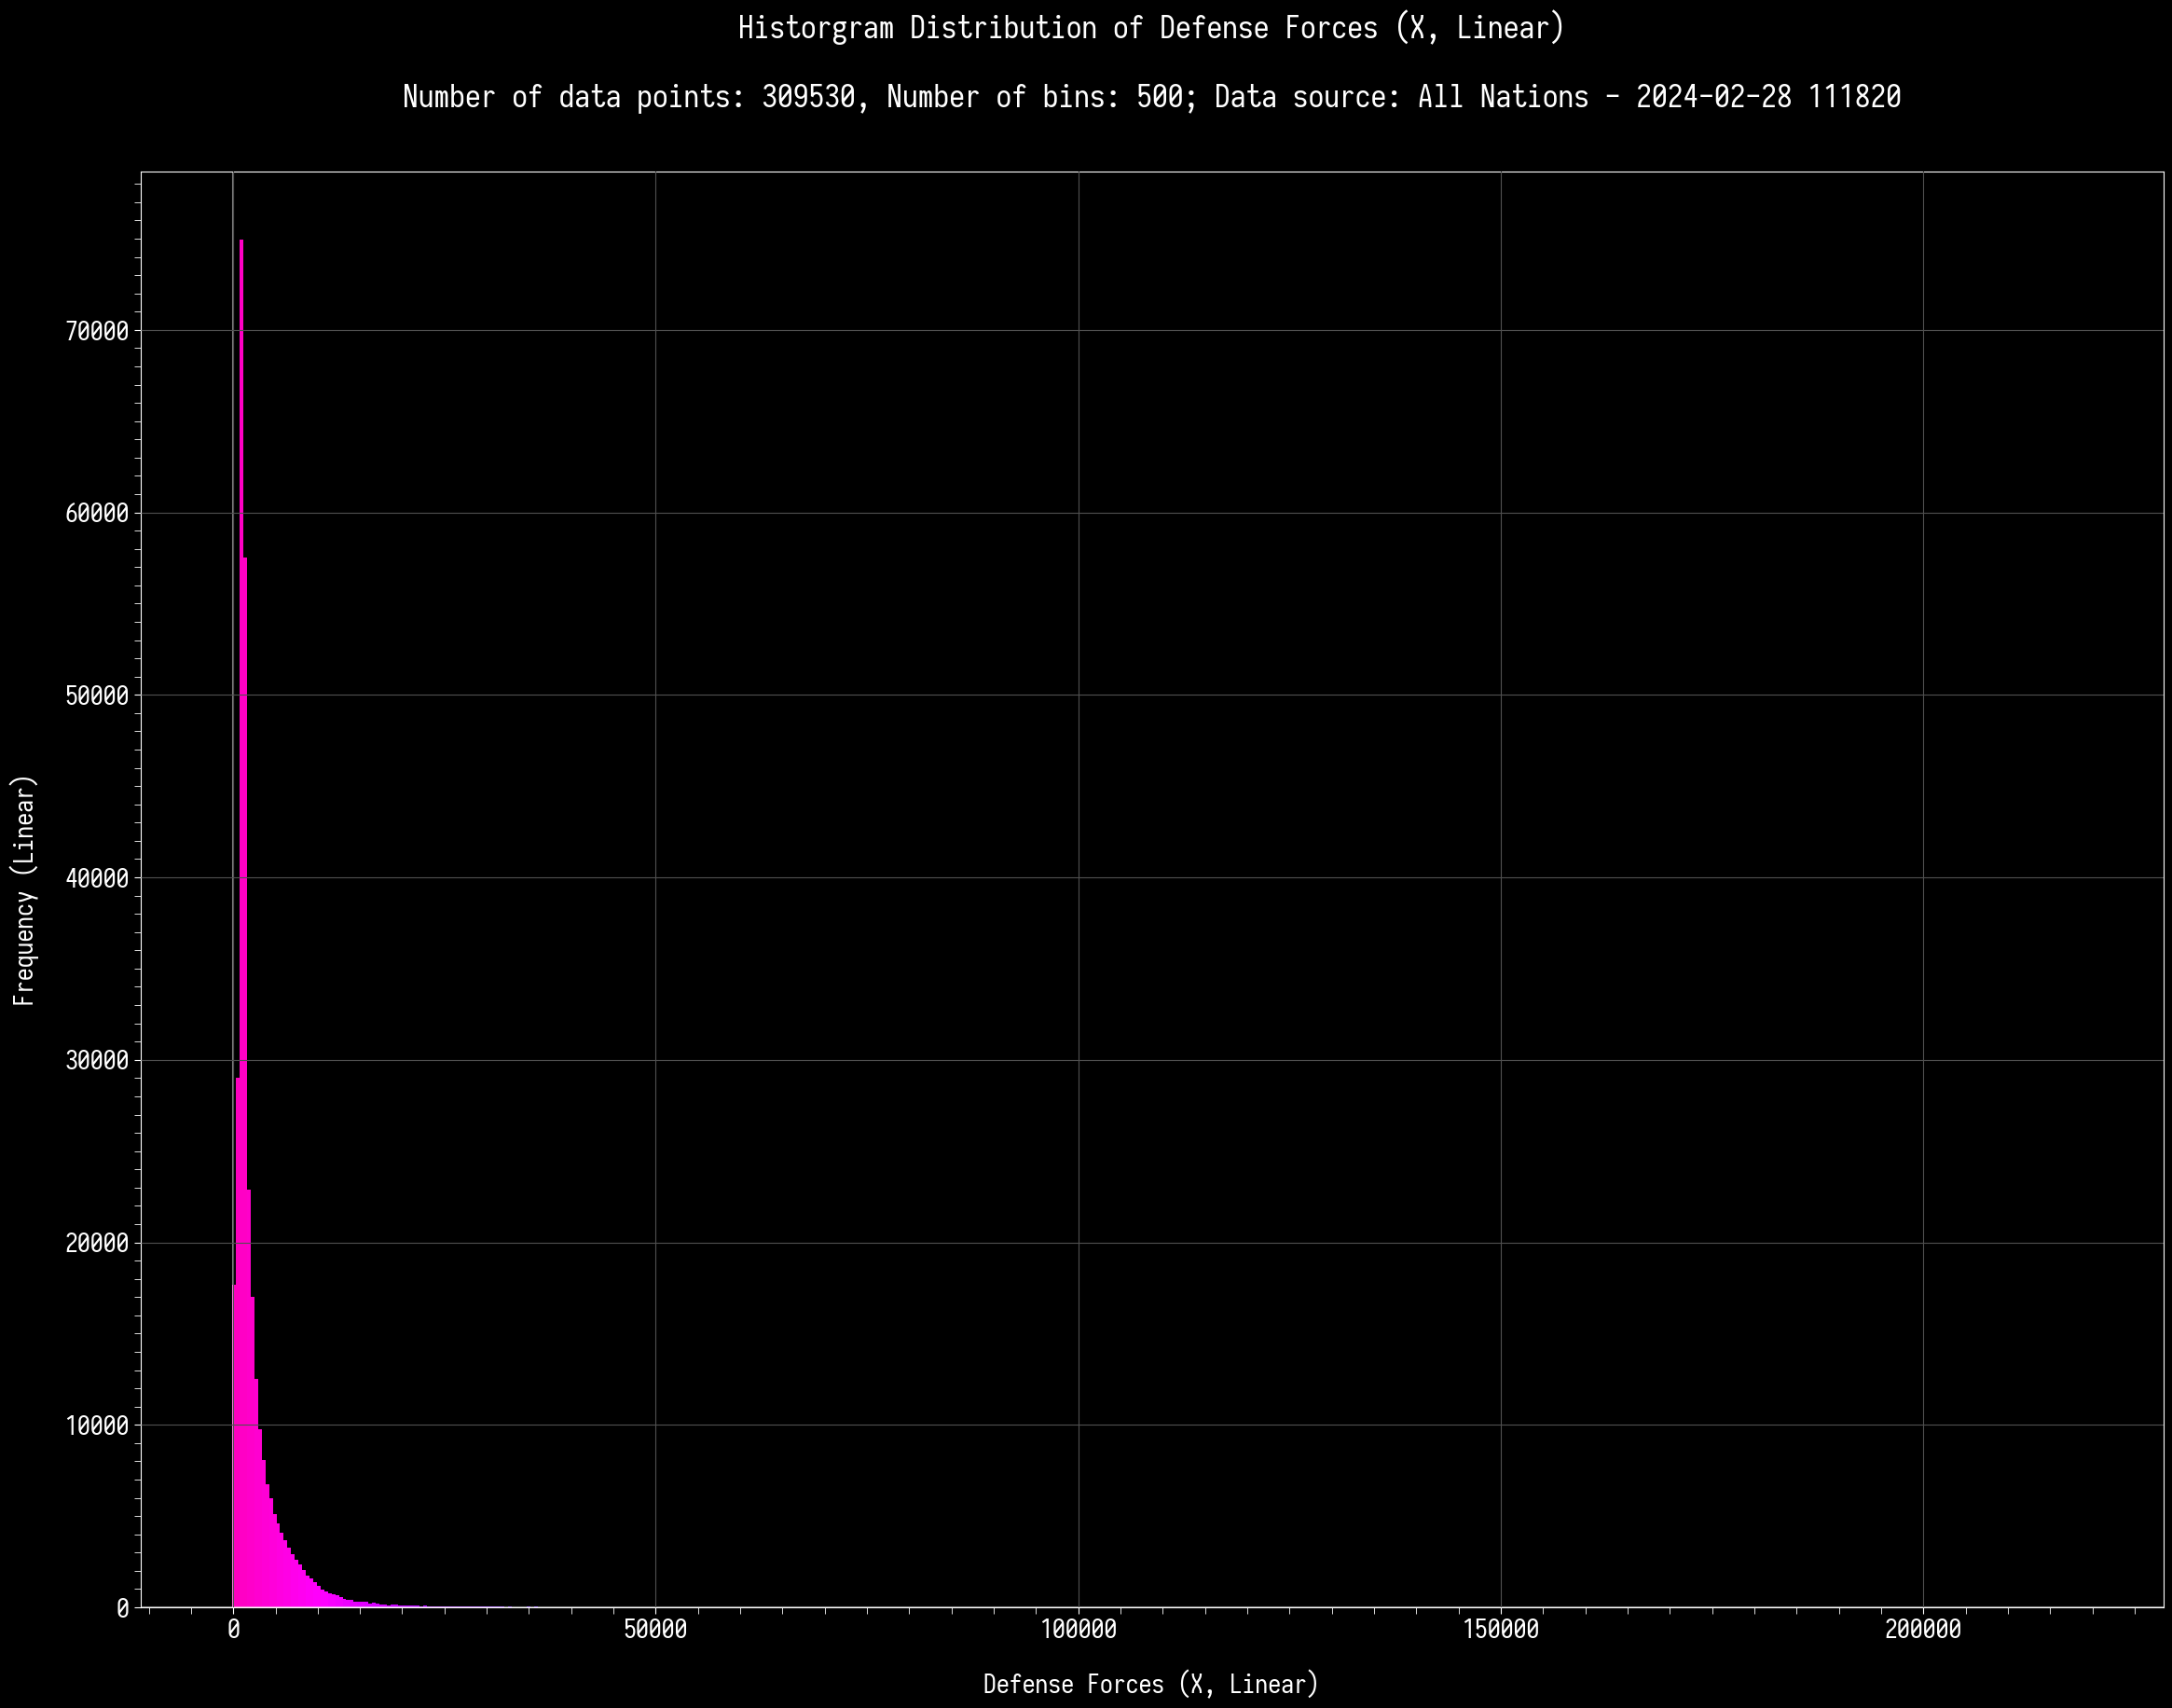

In [15]:
# Histogram for individual data - X-axis.

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fig.set_size_inches(28, 20)
fig.patch.set_color((0/255, 0/255, 0/255))

HistFreqLin = "Frequency (Linear)"
HistFreqLog = "Frequency (Log)"

# AxisLin for linear, AxisLog for Symmetrical Log.
X_lab = XLin
Hist_Freq_lab = HistFreqLin

linthreshx = 1
linthresh_hist = 1

Num_Bins = 500

if X_lab == XLin:
    ax.set_xscale("linear")
else:
    ax.set_xscale("symlog", base = 10, linthresh = linthreshx)
    
if Hist_Freq_lab == HistFreqLin:
    ax.set_yscale("linear")
else:
    ax.set_yscale("symlog", base = 10, linthresh = linthresh_hist)

ax.set_facecolor("black")
ax.set_title("Historgram Distribution of " + X_lab + "\n\n" + "Number of data points: " + str(len(df1)) + ", Number of bins: " + str(Num_Bins) + "; Data source: " + file_name, pad = 50, color ="white")

ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

ax.set_xlabel(X_lab, color = "white", labelpad = 20)
ax.set_ylabel(Hist_Freq_lab, color = "white", labelpad = 20)

ax.axhline(0, color = "white", alpha = 0.5)
ax.axvline(0, color = "white", alpha = 0.5)

grey = 80
ax.xaxis.grid(c = (grey/255, grey/255, grey/255))
ax.yaxis.grid(c = (grey/255, grey/255, grey/255))
ax.set_axisbelow(False)

# --------------------------------------------------------
# Providing minor tick marks for both symlog and linear.
if X_lab == XLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshx))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Hist_Freq_lab == HistFreqLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthresh_hist))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
# ---------------------------------------------------

# Formatting for Population. Populations for NS Nations are often in billions.
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
# ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))

# Set limits on graphs.
# ax.set_xlim(xmin = 3e10, xmax = 5e10)
# ax.set_ylim(ymin = 0, ymax = 5000)

# Inverts y-axis.
# plt.gca().invert_yaxis()

# ---------------------------------------------------

cm = plt.cm.gist_rainbow_r

n, bins, patches = plt.hist(X, Num_Bins)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/Num_Bins))

plt.show()

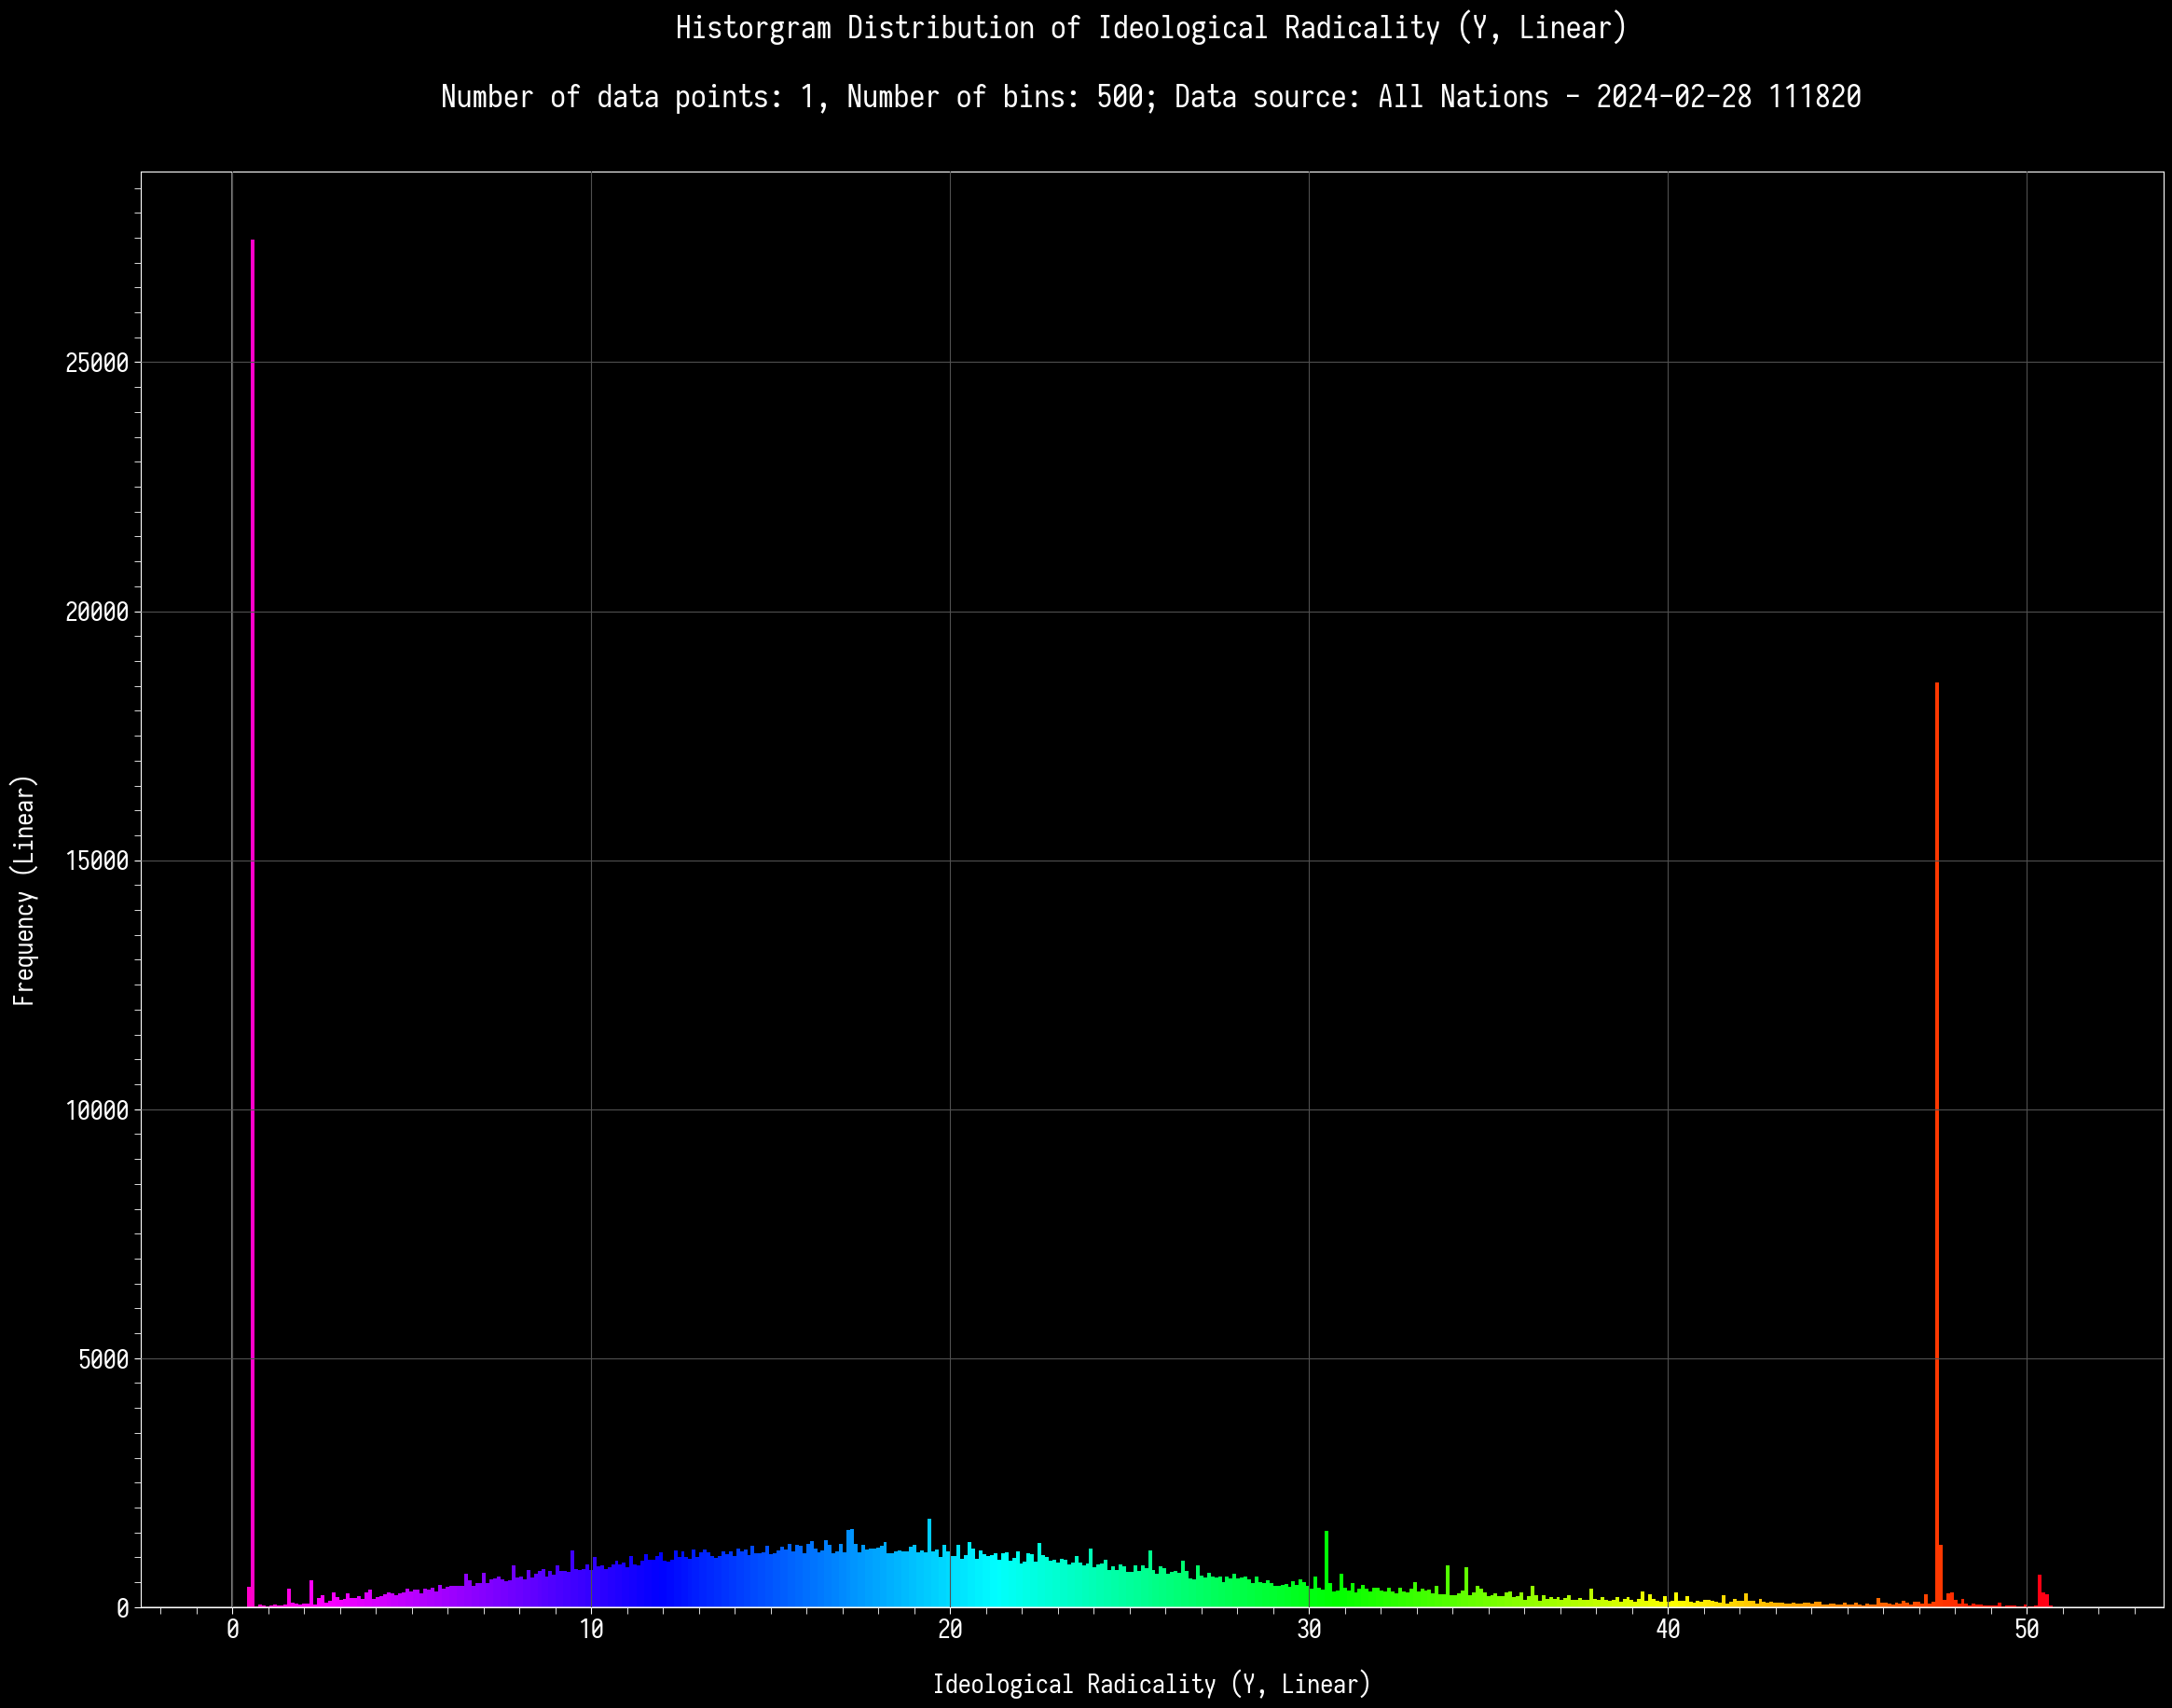

In [16]:
# Histogram for individual data - Y-axis.

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fig.set_size_inches(28, 20)
fig.patch.set_color((0/255, 0/255, 0/255))

HistFreqLin = "Frequency (Linear)"
HistFreqLog = "Frequency (Log)"

# AxisLin for linear, AxisLog for Symmetrical Log.
Y_lab = YLin
Hist_Freq_lab = HistFreqLin

linthreshy = 1
linthresh_hist = 1

Num_Bins = 500

if Y_lab == YLin:
    ax.set_xscale("linear")
else:
    ax.set_xscale("symlog", base = 10, linthresh = linthreshy)
    
if Hist_Freq_lab == HistFreqLin:
    ax.set_yscale("linear")
else:
    ax.set_yscale("symlog", base = 10, linthresh = linthresh_hist)

ax.set_facecolor("black")
title = ax.set_title("Historgram Distribution of " + Y_lab + "\n\n" + "Number of data points: " + str(len(df2)) + ", Number of bins: " + str(Num_Bins) + "; Data source: " + file_name, pad = 50, color ="white")

ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

ax.set_xlabel(Y_lab, color = "white", labelpad = 20)
ax.set_ylabel(Hist_Freq_lab, color = "white", labelpad = 20)

ax.axhline(0, color = "white", alpha = 0.5)
ax.axvline(0, color = "white", alpha = 0.5)

grey = 80
ax.xaxis.grid(c = (grey/255, grey/255, grey/255))
ax.yaxis.grid(c = (grey/255, grey/255, grey/255))
ax.set_axisbelow(False)

# --------------------------------------------------------
# Providing minor tick marks for both symlog and linear.
if Y_lab == YLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshy))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Hist_Freq_lab == HistFreqLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthresh_hist))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
# ---------------------------------------------------

# Formatting for Population. Populations for NS Nations are often in billions.
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
# ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))

# Set limits on graphs.
# ax.set_xlim(xmin = 40, xmax = 100)
# ax.set_ylim(ymin = 0, ymax = 300)

# Inverts y-axis.
# plt.gca().invert_yaxis()

# ---------------------------------------------------

cm = plt.cm.gist_rainbow_r

n, bins, patches = plt.hist((Y), Num_Bins)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/Num_Bins))

plt.show()

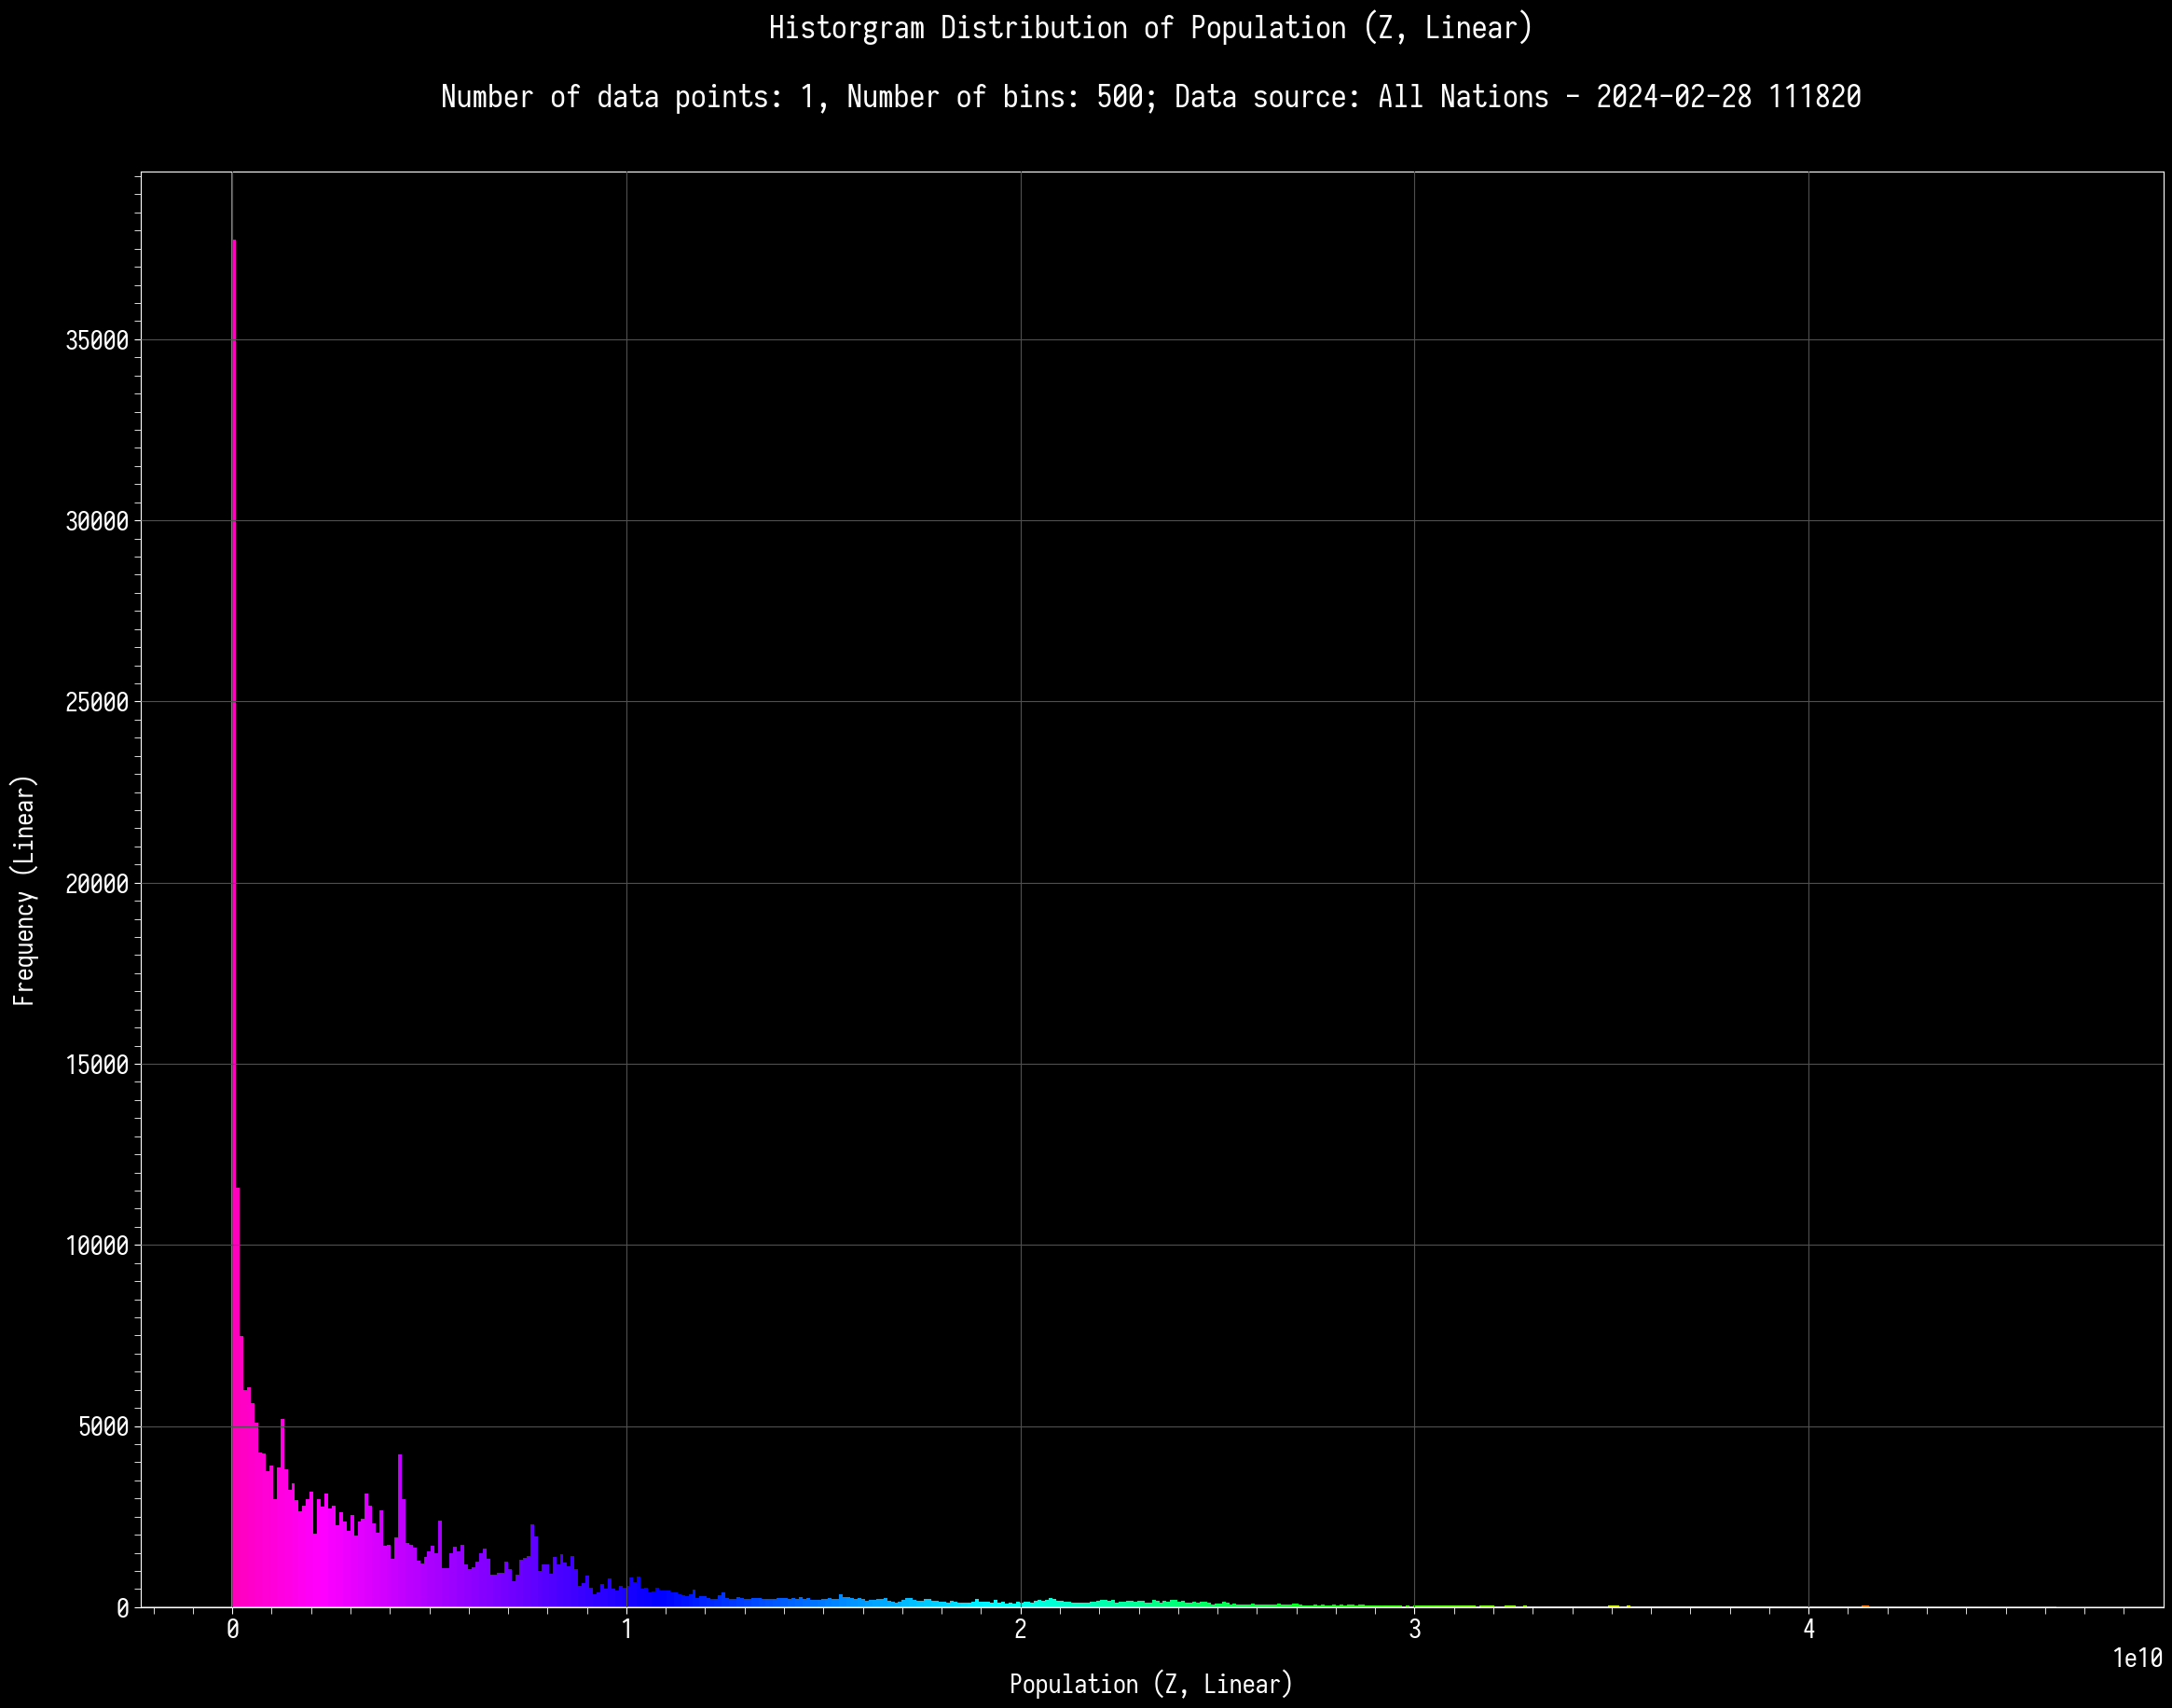

In [17]:
# Histogram for individual data - Z-axis.

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fig.set_size_inches(28, 20)
fig.patch.set_color((0/255, 0/255, 0/255))

HistFreqLin = "Frequency (Linear)"
HistFreqLog = "Frequency (Log)"

# AxisLin for linear, AxisLog for Symmetrical Log.
Z_lab = ZLin
Hist_Freq_lab = HistFreqLin

linthreshz = 1
linthresh_hist = 1

Num_Bins = 500

single_out = False

if Z_lab == ZLin:
    ax.set_xscale("linear")
else:
    ax.set_xscale("symlog", base = 10, linthresh = linthreshz)
    
if Hist_Freq_lab == HistFreqLin:
    ax.set_yscale("linear")
else:
    ax.set_yscale("symlog", base = 10, linthresh = linthresh_hist)

ax.set_facecolor("black")
title = ax.set_title("Historgram Distribution of " + Z_lab + "\n\n" + "Number of data points: " + str(len(df2)) + ", Number of bins: " + str(Num_Bins) + "; Data source: " + file_name, pad = 50, color ="white")
ax.tick_params(which = "both", color = "white", labelcolor = "white", length = 5)
for spine in ax.spines.values():
    spine.set_edgecolor("white")

ax.set_xlabel(Z_lab, color = "white", labelpad = 20)
ax.set_ylabel(Hist_Freq_lab, color = "white", labelpad = 20)

ax.axhline(0, color = "white", alpha = 0.5)
ax.axvline(0, color = "white", alpha = 0.5)

grey = 80
ax.xaxis.grid(c = (grey/255, grey/255, grey/255))
ax.yaxis.grid(c = (grey/255, grey/255, grey/255))
ax.set_axisbelow(False)

# --------------------------------------------------------
# Providing minor tick marks for both symlog and linear.
if Z_lab == ZLog:
    ax.xaxis.set_minor_locator(MinorSymLogLocator(linthreshz))
else:
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

if Hist_Freq_lab == HistFreqLog:
    ax.yaxis.set_minor_locator(MinorSymLogLocator(linthresh_hist))
else:
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
# ---------------------------------------------------

# Formatting for Population. Populations for NS Nations are often in billions.
# ax.xaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))
# ax.yaxis.set_major_formatter(OOMFormatter(9, "%1.1f"))

# Set limits on graphs.
# ax.set_xlim(xmin = 0.5e6, xmax = 3e6)
# ax.set_ylim(ymin = 0, ymax = 10)

# Inverts y-axis.
# plt.gca().invert_yaxis()

# ---------------------------------------------------

cm = plt.cm.gist_rainbow_r

n, bins, patches = plt.hist(Z, Num_Bins)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/Num_Bins))

plt.show()